In [5]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error, adjusted_rand_score
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline

In [2]:
def fit_scatter(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Observed AUC')
    ax.set_ylabel('Predicted AUC')
    ax.set_title('')

In [3]:
data_path = os.path.join(os.getcwd(), 'datasets', 'features.csv')
data_path_rp = os.path.join(os.getcwd(), 'datasets', 'rp_features.csv')
data_path_nrp = os.path.join(os.getcwd(), 'datasets', 'nrp_features.csv')
data_path_extended = os.path.join(os.getcwd(), 'datasets', 'extended_features.csv')

gene_features = pd.read_csv(data_path, delimiter = ',')
rp_gene_features = pd.read_csv(data_path_rp, delimiter = ',')
nrp_gene_features = pd.read_csv(data_path_nrp, delimiter = ',')
extended_features = pd.read_csv(data_path_extended, delimiter = ',')

print('Number of data points: {}. Number of attributes: {}'.format(gene_features.shape[0],gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(extended_features.shape[0],extended_features.shape[1]))

Number of data points: 117. Number of attributes: 101
Number of data points: 117. Number of attributes: 107


In [9]:
X = gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
y = gene_features['AUC']


X_rp = rp_gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
y_rp = rp_gene_features['AUC']

X_nrp = nrp_gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
y_nrp = nrp_gene_features['AUC']

X_extended = extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
y_extended = extended_features['AUC']

In [5]:
pca_2 = PCA(n_components = 3).fit(X)
X_2d = pca_2.transform(X)
kmeans_pca = KMeans(n_clusters=3, random_state=1337)  
kmeans_pca.fit(X_2d)
print("Adjusted rand index of the model: {}".format( adjusted_rand_score(y, kmeans_pca.labels_)))

Adjusted rand index of the model: 0.0021241741672083313


In [6]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_2d[:, 0].min() , X_2d[:, 0].max() 
y_min, y_max = X_2d[:, 1].min() , X_2d[:, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_pca.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_2d[:, 0], X_2d[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans_pca.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

MemoryError: 

In [8]:
kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

In [9]:
lr1 = LinearRegression()
lr2 = LinearRegression()

predictions1 = cross_val_predict(lr1,X,y=y,cv=kf)
predictions2 = cross_val_predict(lr1,X_extended,y=y_extended,cv=kf)

print('Data')
print('Coefficient of determination: {}'.format(r2_score(y, predictions1)))
print('Mean absolute error: {}'.format(mean_absolute_error(y, predictions1)))
print('Root mean squared error: {}'.format(np.sqrt(mean_squared_error(y, predictions1))))
print('\n')
print('Extended Data')
print('Coefficient of determination: {}'.format(r2_score(y, predictions2)))
print('Mean absolute error: {}'.format(mean_absolute_error(y, predictions2)))
print('Root mean squared error: {}'.format(np.sqrt(mean_squared_error(y, predictions2))))

Data
Coefficient of determination: -7.218302015333855
Mean absolute error: 0.4702581683241454
Root mean squared error: 0.6546933285937646


Extended Data
Coefficient of determination: -3.3354838774388638
Mean absolute error: 0.3297615508995484
Root mean squared error: 0.47551656947204896


In [10]:
kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

rfr1 = RandomForestRegressor()
rfr2 = RandomForestRegressor()

predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(rfr2,X_extended,y=y_extended,cv=kf)

print('RandomForestRegressor R^2: {}'.format(r2_score(y, predictions_rfr1)))
print('RandomForestRegressor MAE: {}'.format(mean_absolute_error(y, predictions_rfr1)))
print('RandomForestRegressor RMSE: {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
print('RandomForestRegressor CC: \n{}'.format(np.corrcoef(y, predictions_rfr1)))
print('\n')
print('RandomForestRegressor R^2: {}'.format(r2_score(y, predictions_rfr2)))
print('RandomForestRegressor MAE: {}'.format(mean_absolute_error(y, predictions_rfr2)))
print('RandomForestRegressor RMSE: {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr2))))
print('RandomForestRegressor CC: \n{}'.format(np.corrcoef(y, predictions_rfr2)))

RandomForestRegressor R^2: 0.27011419834643235
RandomForestRegressor MAE: 0.14499401709401707
RandomForestRegressor RMSE: 0.19510766192948378
RandomForestRegressor CC: 
[[ 1.          0.52453297]
 [ 0.52453297  1.        ]]


RandomForestRegressor R^2: 0.35984866243806024
RandomForestRegressor MAE: 0.1364846153846154
RandomForestRegressor RMSE: 0.18272088728323493
RandomForestRegressor CC: 
[[ 1.          0.60009927]
 [ 0.60009927  1.        ]]


Data
RandomForestRegressor R^2: 0.2856068926890162
RandomForestRegressor MAE: 0.1387846153846154
RandomForestRegressor RMSE: 0.19302585938977812
RandomForestRegressor CC: 
[[ 1.         0.5448605]
 [ 0.5448605  1.       ]]


Extended
RandomForestRegressor R^2: 0.2434478643005561
RandomForestRegressor MAE: 0.14120769230769228
RandomForestRegressor RMSE: 0.1986398129760127
RandomForestRegressor CC: 
[[ 1.          0.51005226]
 [ 0.51005226  1.        ]]


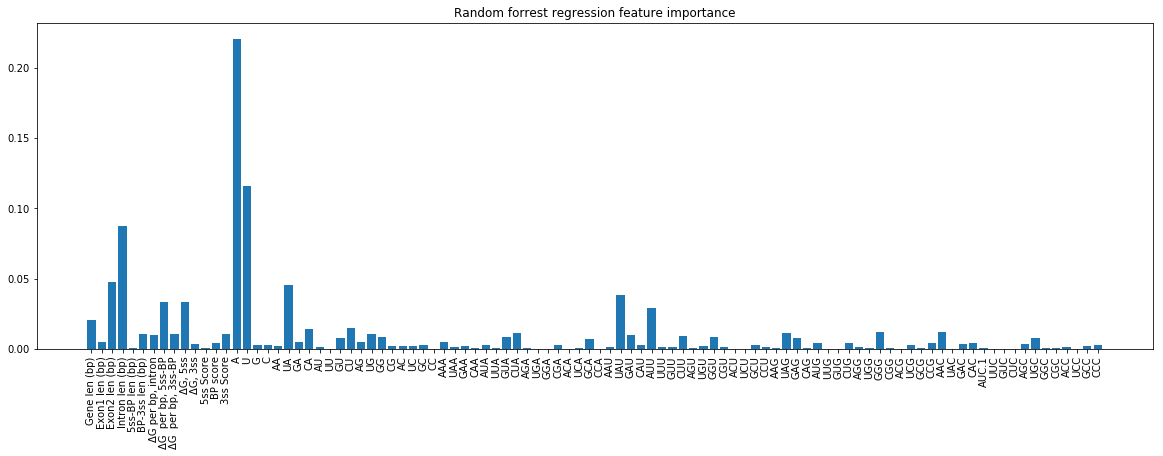

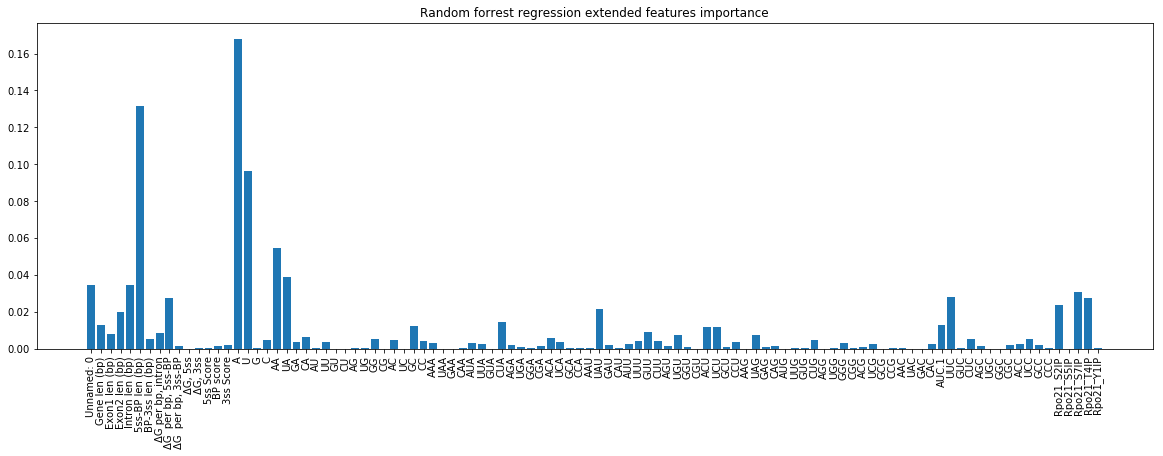

In [4]:
kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

rfr1 = RandomForestRegressor()
rfr2 = RandomForestRegressor()

predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(rfr2,X_extended,y=y_extended,cv=kf)

print('Data')
print('RandomForestRegressor R^2: {}'.format(r2_score(y, predictions_rfr1)))
print('RandomForestRegressor MAE: {}'.format(mean_absolute_error(y, predictions_rfr1)))
print('RandomForestRegressor RMSE: {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
print('RandomForestRegressor CC: \n{}'.format(np.corrcoef(y, predictions_rfr1)))

rfr1.fit(X,y)
fig, ax1 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr1.feature_importances_))
ax1.bar(xx, rfr1.feature_importances_)
ax1.set_xticks(xx)
ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax1.set_title('Random forrest regression feature importance')
fig.savefig('Features_importance.pdf')

print('\n')
print('Extended')
print('RandomForestRegressor R^2: {}'.format(r2_score(y_extended, predictions_rfr2)))
print('RandomForestRegressor MAE: {}'.format(mean_absolute_error(y_extended, predictions_rfr2)))
print('RandomForestRegressor RMSE: {}'.format(np.sqrt(mean_squared_error(y_extended, predictions_rfr2))))
print('RandomForestRegressor CC: \n{}'.format(np.corrcoef(y_extended, predictions_rfr2)))

rfr2.fit(X_extended,y_extended)
fig2, ax2 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr2.feature_importances_))
ax2.bar(xx, rfr2.feature_importances_)
ax2.set_xticks(xx)
ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax2.set_title('Random forrest regression extended features importance')
fig2.savefig('Features_importance2.pdf')

Normal feature space
Coefficient of determination R^2: 0.3533447458067761
Mean squared error:               0.03372613269061539
Mean absolute error:              0.1325095555555555
Root mean squared error:          0.1836467606319681
Correlation Coefficient:          0.5972983280622173


Extended feature space
Coefficient of determination R^2: 0.41608857506293984
Mean squared error:               0.03045374497352991
Mean absolute error:              0.1273354102564102
Root mean squared error:          0.17451001396346832
Correlation Coefficient:          0.6538661778284606


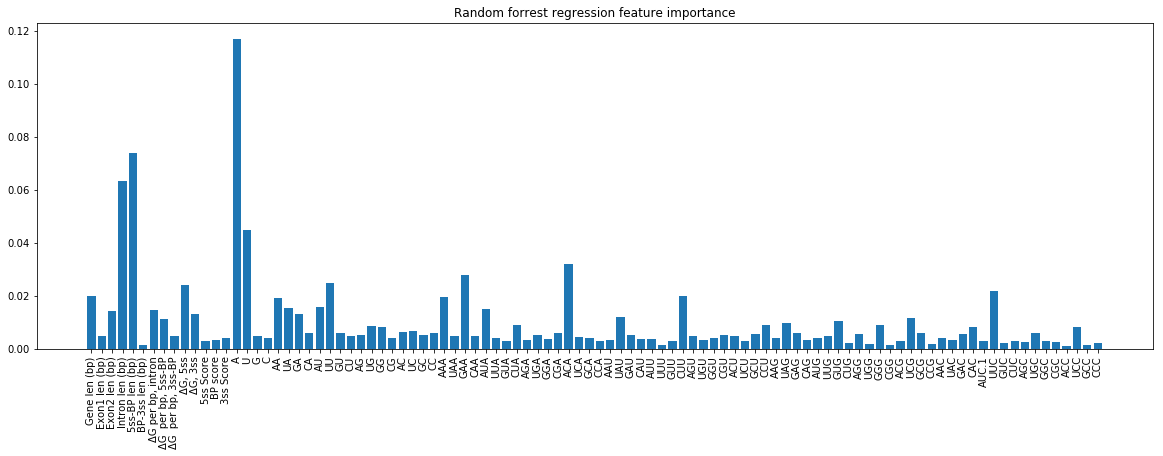

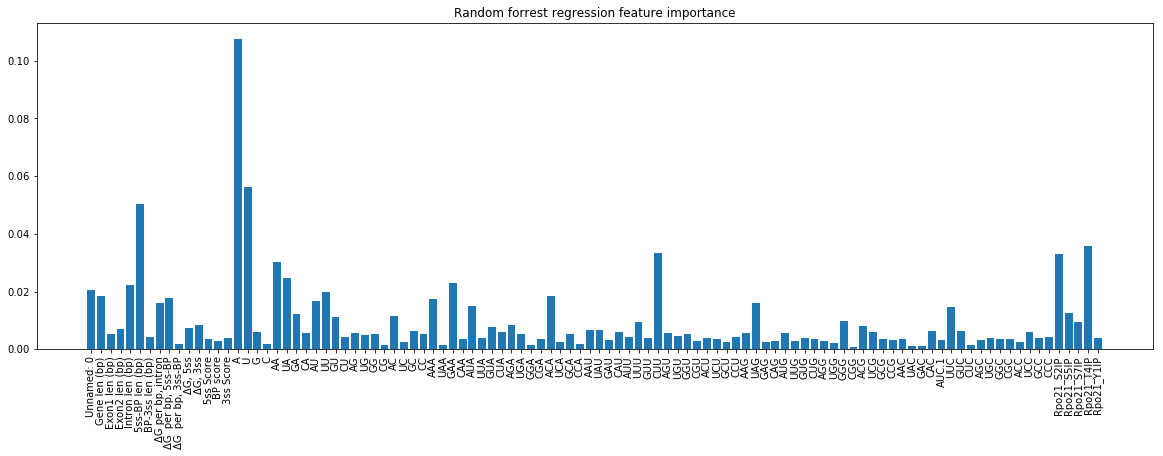

In [11]:
kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

rfr1 = RandomForestRegressor(n_estimators=100, 
                            criterion='mse', 
                            max_features=25, 
                            max_depth=20, 
                            n_jobs=2,
                            random_state=1337)

rfr2 = RandomForestRegressor(n_estimators=100, 
                            criterion='mse', 
                            max_features=25, 
                            max_depth=20, 
                            n_jobs=2,
                            random_state=1337)

predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(rfr2,X_extended,y=y_extended,cv=kf)

print('Normal feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr1)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr1)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr1)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr1)[0][1]))

rfr1.fit(X,y)
fig, ax1 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr1.feature_importances_))
ax1.bar(xx, rfr1.feature_importances_)
ax1.set_xticks(xx)
ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax1.set_title('Random forrest regression feature importance')
fig.savefig('Features_importance.png')
print('\n')
print('Extended feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr2)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr2)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr2)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr2))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr2)[0][1]))

rfr2.fit(X_extended,y_extended)
fig2, ax2 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr2.feature_importances_))
ax2.bar(xx, rfr2.feature_importances_)
ax2.set_xticks(xx)
ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax2.set_title('Random forrest regression feature importance')
fig2.savefig('Features_importance2.png')

In [17]:
from ipywidgets import FloatProgress
from IPython.display import display

f = FloatProgress(min=0, max=1080)
display(f)

results_1 = np.zeros((12,10,9))
results_2 = np.zeros((12,10,9))
i = 0
for max_features in [5,10,15,20,25,30,45,50,55,60,70,80]:
    j = 0
    for max_depth in [5,10,15,20,25,30,50,60,80,100]:
        k = 0
        for n_estimators in [10,20,30,40,50,60,80,90,100]:
            
            
            kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

            rfr1 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X_extended,y=y_extended,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr1)))
            print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr1)))
            print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr1)))
            print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
            print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr1)[0][1]))
            
            print('\n')
            print('Extended feature space')
            print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr2)))
            print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr2)))
            print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr2)))
            print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr2))))
            print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr2)[0][1]))
            print('-------------------------------------------------------\n')
            
            
            results_1[i][j][k]=r2_score(y, predictions_rfr1)
            results_2[i][j][k]=r2_score(y, predictions_rfr2)
            f.value += 1
            
            k += 1
        j += 1
    i += 1
            # rfr1.fit(X,y)
            # fig, ax1 = plt.subplots(figsize=(20,6))
            # xx = np.arange(len(rfr1.feature_importances_))
            # ax1.bar(xx, rfr1.feature_importances_)
            # ax1.set_xticks(xx)
            # ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
            # ax1.set_title('Random forrest regression feature importance')
            # fig.savefig('Features_importance.png')

            # rfr2.fit(X_extended,y_extended)
            # fig2, ax2 = plt.subplots(figsize=(20,6))
            # xx = np.arange(len(rfr2.feature_importances_))
            # ax2.bar(xx, rfr2.feature_importances_)
            # ax2.set_xticks(xx)
            # ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
            # ax2.set_title('Random forrest regression feature importance')
            # fig2.savefig('Features_importance2.png')

FloatProgress(value=0.0, max=1080.0)

max_features: 5; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.32593903458010076
Mean squared error:               0.03515547026626796
Mean absolute error:              0.14173351167018933
Root mean squared error:          0.1874979206985186
Correlation Coefficient:          0.5737074684069972


Extended feature space
Coefficient of determination R^2: 0.3296214895545304
Mean squared error:               0.034963412807073914
Mean absolute error:              0.14350953577481435
Root mean squared error:          0.18698506038471072
Correlation Coefficient:          0.5801668506479677
-------------------------------------------------------

max_features: 5; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3026746350605406
Mean squared error:               0.03636881883194702
Mean absolute error:              0.14484901908078682
Root mean squared error:          0.1907061059115492
Correlation Coefficient: 

max_features: 5; max_depth: 10; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.3521654597681977
Mean squared error:               0.03378763804011867
Mean absolute error:              0.13724547321292072
Root mean squared error:          0.18381413993520376
Correlation Coefficient:          0.6087662445216095


Extended feature space
Coefficient of determination R^2: 0.3627260965227779
Mean squared error:               0.03323685084064447
Mean absolute error:              0.13548594840876718
Root mean squared error:          0.1823097661691344
Correlation Coefficient:          0.6198763534964438
-------------------------------------------------------

max_features: 5; max_depth: 10; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3677544083684334
Mean squared error:               0.03297460057449925
Mean absolute error:              0.13674612776449752
Root mean squared error:          0.1815890981708408
Correlation Coefficient: 

max_features: 5; max_depth: 15; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3610651488547011
Mean squared error:               0.03332347712425151
Mean absolute error:              0.1366829728835978
Root mean squared error:          0.1825471914992162
Correlation Coefficient:          0.6154914741906077


Extended feature space
Coefficient of determination R^2: 0.3435532141292782
Mean squared error:               0.034236807419473284
Mean absolute error:              0.13930620378849537
Root mean squared error:          0.18503190919263976
Correlation Coefficient:          0.6015361447228207
-------------------------------------------------------

max_features: 5; max_depth: 15; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3549341572308997
Mean squared error:               0.03364323736077406
Mean absolute error:              0.13715407181296066
Root mean squared error:          0.18342092945128716
Correlation Coefficient:

max_features: 5; max_depth: 25; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3649251623951607
Mean squared error:               0.03312215914529914
Mean absolute error:              0.1400119658119658
Root mean squared error:          0.1819949426365995
Correlation Coefficient:          0.6134669975877375


Extended feature space
Coefficient of determination R^2: 0.31474800270371084
Mean squared error:               0.03573913555555556
Mean absolute error:              0.14377264957264954
Root mean squared error:          0.18904797157217942
Correlation Coefficient:          0.5635897874940647
-------------------------------------------------------

max_features: 5; max_depth: 25; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3731523511033644
Mean squared error:               0.032693072307692306
Mean absolute error:              0.1374854700854701
Root mean squared error:          0.18081225707261195
Correlation Coefficient:

max_features: 5; max_depth: 30; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.35580198516745953
Mean squared error:               0.033597976025694434
Mean absolute error:              0.13671557692307693
Root mean squared error:          0.18329750687255525
Correlation Coefficient:          0.6062960689354996


Extended feature space
Coefficient of determination R^2: 0.35759400532580365
Mean squared error:               0.033504513691239315
Mean absolute error:              0.13614850427350428
Root mean squared error:          0.1830423822267382
Correlation Coefficient:          0.6116143394217088
-------------------------------------------------------

max_features: 5; max_depth: 30; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3687088965618408
Mean squared error:               0.03292481949678631
Mean absolute error:              0.13659998290598283
Root mean squared error:          0.18145197573128352
Correlation Coeffici

max_features: 5; max_depth: 50; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3579193262180611
Mean squared error:               0.03348754666668
Mean absolute error:              0.13671654914529904
Root mean squared error:          0.18299602910085236
Correlation Coefficient:          0.6114909558354547


Extended feature space
Coefficient of determination R^2: 0.3458040404598245
Mean squared error:               0.03411941617120725
Mean absolute error:              0.13901955128205118
Root mean squared error:          0.18471441787583137
Correlation Coefficient:          0.6035798842053417
-------------------------------------------------------

max_features: 5; max_depth: 50; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3529460411220825
Mean squared error:               0.03374692702733986
Mean absolute error:              0.1369301899335232
Root mean squared error:          0.1837033669461174
Correlation Coefficient:    

max_features: 5; max_depth: 80; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3649251623951606
Mean squared error:               0.033122159145299146
Mean absolute error:              0.14001196581196582
Root mean squared error:          0.18199494263659952
Correlation Coefficient:          0.6134669975877374


Extended feature space
Coefficient of determination R^2: 0.31474800270371084
Mean squared error:               0.03573913555555556
Mean absolute error:              0.14377264957264954
Root mean squared error:          0.18904797157217942
Correlation Coefficient:          0.5635897874940649
-------------------------------------------------------

max_features: 5; max_depth: 80; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.37315235110336453
Mean squared error:               0.032693072307692306
Mean absolute error:              0.1374854700854701
Root mean squared error:          0.18081225707261195
Correlation Coeffici

max_features: 5; max_depth: 100; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.35580198516745953
Mean squared error:               0.033597976025694434
Mean absolute error:              0.1367155769230769
Root mean squared error:          0.18329750687255525
Correlation Coefficient:          0.6062960689354997


Extended feature space
Coefficient of determination R^2: 0.35759400532580343
Mean squared error:               0.03350451369123932
Mean absolute error:              0.13614850427350428
Root mean squared error:          0.1830423822267382
Correlation Coefficient:          0.6116143394217088
-------------------------------------------------------

max_features: 5; max_depth: 100; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3687088965618409
Mean squared error:               0.0329248194967863
Mean absolute error:              0.13659998290598283
Root mean squared error:          0.18145197573128352
Correlation Coefficie

max_features: 10; max_depth: 5; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3303940691574371
Mean squared error:               0.0349231191234879
Mean absolute error:              0.1397237877543718
Root mean squared error:          0.18687728359404174
Correlation Coefficient:          0.5792313185220354


Extended feature space
Coefficient of determination R^2: 0.3442475810099397
Mean squared error:               0.03420059289960152
Mean absolute error:              0.1400804305521654
Root mean squared error:          0.1849340230990542
Correlation Coefficient:          0.5957510969312131
-------------------------------------------------------

max_features: 10; max_depth: 5; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3332783399704944
Mean squared error:               0.03477269074681261
Mean absolute error:              0.1400600212762987
Root mean squared error:          0.18647437021428068
Correlation Coefficient:    

max_features: 10; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3025745542326279
Mean squared error:               0.03637403852089269
Mean absolute error:              0.14591524216524215
Root mean squared error:          0.19071979058527902
Correlation Coefficient:          0.5515927997287453


Extended feature space
Coefficient of determination R^2: 0.2831355930949818
Mean squared error:               0.03738787236581197
Mean absolute error:              0.14512153846153844
Root mean squared error:          0.19335943826410948
Correlation Coefficient:          0.533884919710324
-------------------------------------------------------

max_features: 10; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3344816956035992
Mean squared error:               0.03470993005401234
Mean absolute error:              0.14120719373219376
Root mean squared error:          0.18630601185687043
Correlation Coefficien

max_features: 10; max_depth: 20; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.3438983074979861
Mean squared error:               0.03421880916666667
Mean absolute error:              0.13860726495726497
Root mean squared error:          0.18498326726130304
Correlation Coefficient:          0.5913828703793307


Extended feature space
Coefficient of determination R^2: 0.35624517602189376
Mean squared error:               0.03357486152462607
Mean absolute error:              0.13617134615384616
Root mean squared error:          0.18323444415454773
Correlation Coefficient:          0.6015364432132211
-------------------------------------------------------

max_features: 10; max_depth: 20; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3530909588453107
Mean squared error:               0.033739368882051285
Mean absolute error:              0.13867999999999994
Root mean squared error:          0.1836827941916479
Correlation Coeffici

max_features: 10; max_depth: 25; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.36066106449312996
Mean squared error:               0.03334455203659186
Mean absolute error:              0.13605587606837596
Root mean squared error:          0.18260490693459433
Correlation Coefficient:          0.6104318236035593


Extended feature space
Coefficient of determination R^2: 0.3657892140389215
Mean squared error:               0.03307709476176547
Mean absolute error:              0.13557787393162385
Root mean squared error:          0.18187109380483055
Correlation Coefficient:          0.6139759120475836
-------------------------------------------------------

max_features: 10; max_depth: 25; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3654202442240584
Mean squared error:               0.03309633828426717
Mean absolute error:              0.13602640075973402
Root mean squared error:          0.18192399040331972
Correlation Coeffici

max_features: 10; max_depth: 50; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30765852324392107
Mean squared error:               0.036108885470085464
Mean absolute error:              0.14529401709401707
Root mean squared error:          0.19002338137735963
Correlation Coefficient:          0.5563450370351177


Extended feature space
Coefficient of determination R^2: 0.2900057984765214
Mean squared error:               0.037029558632478636
Mean absolute error:              0.14451623931623933
Root mean squared error:          0.1924306592840097
Correlation Coefficient:          0.5392678094887633
-------------------------------------------------------

max_features: 10; max_depth: 50; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.33538725808553693
Mean squared error:               0.034662700683760685
Mean absolute error:              0.14083162393162396
Root mean squared error:          0.1861792165730662
Correlation Coeffi

max_features: 10; max_depth: 60; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.3438983074979861
Mean squared error:               0.03421880916666667
Mean absolute error:              0.13860726495726497
Root mean squared error:          0.18498326726130304
Correlation Coefficient:          0.5913828703793309


Extended feature space
Coefficient of determination R^2: 0.35624517602189376
Mean squared error:               0.03357486152462607
Mean absolute error:              0.13617134615384616
Root mean squared error:          0.18323444415454773
Correlation Coefficient:          0.601536443213221
-------------------------------------------------------

max_features: 10; max_depth: 60; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3530909588453107
Mean squared error:               0.033739368882051285
Mean absolute error:              0.13867999999999994
Root mean squared error:          0.1836827941916479
Correlation Coefficie

max_features: 10; max_depth: 80; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.36066106449312996
Mean squared error:               0.03334455203659186
Mean absolute error:              0.13605587606837596
Root mean squared error:          0.18260490693459433
Correlation Coefficient:          0.6104318236035592


Extended feature space
Coefficient of determination R^2: 0.3657892140389214
Mean squared error:               0.03307709476176548
Mean absolute error:              0.13557787393162385
Root mean squared error:          0.18187109380483057
Correlation Coefficient:          0.6139759120475836
-------------------------------------------------------

max_features: 10; max_depth: 80; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3654202442240584
Mean squared error:               0.03309633828426717
Mean absolute error:              0.13602640075973402
Root mean squared error:          0.18192399040331972
Correlation Coeffici

max_features: 15; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.33426042431139724
Mean squared error:               0.034721470399371075
Mean absolute error:              0.13978646282517038
Root mean squared error:          0.18633698076165953
Correlation Coefficient:          0.5796312776266335


Extended feature space
Coefficient of determination R^2: 0.38510956604393376
Mean squared error:               0.03206944694459373
Mean absolute error:              0.13318550034150764
Root mean squared error:          0.17907944311001678
Correlation Coefficient:          0.6227835673293204
-------------------------------------------------------

max_features: 15; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3459897089088334
Mean squared error:               0.034109732682660404
Mean absolute error:              0.13814918449390504
Root mean squared error:          0.18468820396186758
Correlation Coeffic

max_features: 15; max_depth: 10; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.36997646201726975
Mean squared error:               0.032858709957790645
Mean absolute error:              0.13152838152656376
Root mean squared error:          0.18126971605260114
Correlation Coefficient:          0.615165705412741


Extended feature space
Coefficient of determination R^2: 0.3938235301459564
Mean squared error:               0.03161497246586591
Mean absolute error:              0.13169799617303252
Root mean squared error:          0.17780599670952021
Correlation Coefficient:          0.6346638679130636
-------------------------------------------------------

max_features: 15; max_depth: 10; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3738878713266567
Mean squared error:               0.032654711446187625
Mean absolute error:              0.13231026382898653
Root mean squared error:          0.18070614667516882
Correlation Coeffic

max_features: 15; max_depth: 15; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3574589055624561
Mean squared error:               0.03351155978344313
Mean absolute error:              0.13423962962962954
Root mean squared error:          0.1830616283753729
Correlation Coefficient:          0.6089999120994961


Extended feature space
Coefficient of determination R^2: 0.38966733369719186
Mean squared error:               0.03183173778557893
Mean absolute error:              0.13064041702510448
Root mean squared error:          0.1784145111407111
Correlation Coefficient:          0.6341684450235557
-------------------------------------------------------

max_features: 15; max_depth: 15; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.35469165277499015
Mean squared error:               0.033655885116135265
Mean absolute error:              0.13519601930990816
Root mean squared error:          0.18345540361661541
Correlation Coeffici

max_features: 15; max_depth: 25; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.26241095516122337
Mean squared error:               0.03846876034188034
Mean absolute error:              0.14291794871794872
Root mean squared error:          0.19613454652834708
Correlation Coefficient:          0.5124331206571991


Extended feature space
Coefficient of determination R^2: 0.341705811631015
Mean squared error:               0.0343331582051282
Mean absolute error:              0.13883846153846158
Root mean squared error:          0.1852920888897532
Correlation Coefficient:          0.5860048439300565
-------------------------------------------------------

max_features: 15; max_depth: 25; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3102664074026691
Mean squared error:               0.035972871965811976
Mean absolute error:              0.14043076923076922
Root mean squared error:          0.18966515749027804
Correlation Coefficien

max_features: 15; max_depth: 30; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.34376602494542885
Mean squared error:               0.034225708327991454
Mean absolute error:              0.13344380341880344
Root mean squared error:          0.1850019143900718
Correlation Coefficient:          0.5921897707067678


Extended feature space
Coefficient of determination R^2: 0.3845968656208262
Mean squared error:               0.03209618669871795
Mean absolute error:              0.13266794871794874
Root mean squared error:          0.17915408646949127
Correlation Coefficient:          0.6309005324040629
-------------------------------------------------------

max_features: 15; max_depth: 30; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.34906186472449807
Mean squared error:               0.03394950521367522
Mean absolute error:              0.13525213675213676
Root mean squared error:          0.1842539150565741
Correlation Coeffici

max_features: 15; max_depth: 50; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.35661608192594296
Mean squared error:               0.033555517025908116
Mean absolute error:              0.1344426282051281
Root mean squared error:          0.18318165035261616
Correlation Coefficient:          0.6083787827172772


Extended feature space
Coefficient of determination R^2: 0.39003081340229695
Mean squared error:               0.031812780598290596
Mean absolute error:              0.13070641025641022
Root mean squared error:          0.17836137641958977
Correlation Coefficient:          0.6346791597202391
-------------------------------------------------------

max_features: 15; max_depth: 50; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3541704931877456
Mean squared error:               0.03368306605571384
Mean absolute error:              0.13529525166191828
Root mean squared error:          0.18352946917515411
Correlation Coeffi

max_features: 15; max_depth: 80; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.26241095516122326
Mean squared error:               0.03846876034188035
Mean absolute error:              0.14291794871794872
Root mean squared error:          0.19613454652834708
Correlation Coefficient:          0.512433120657199


Extended feature space
Coefficient of determination R^2: 0.341705811631015
Mean squared error:               0.0343331582051282
Mean absolute error:              0.13883846153846158
Root mean squared error:          0.1852920888897532
Correlation Coefficient:          0.5860048439300564
-------------------------------------------------------

max_features: 15; max_depth: 80; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3102664074026691
Mean squared error:               0.035972871965811976
Mean absolute error:              0.14043076923076922
Root mean squared error:          0.18966515749027804
Correlation Coefficient

max_features: 15; max_depth: 100; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.34376602494542885
Mean squared error:               0.034225708327991454
Mean absolute error:              0.13344380341880344
Root mean squared error:          0.1850019143900718
Correlation Coefficient:          0.5921897707067675


Extended feature space
Coefficient of determination R^2: 0.3845968656208262
Mean squared error:               0.03209618669871795
Mean absolute error:              0.13266794871794876
Root mean squared error:          0.17915408646949127
Correlation Coefficient:          0.630900532404063
-------------------------------------------------------

max_features: 15; max_depth: 100; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.34906186472449807
Mean squared error:               0.033949505213675214
Mean absolute error:              0.13525213675213674
Root mean squared error:          0.18425391505657407
Correlation Coeff

max_features: 20; max_depth: 5; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3471107948304524
Mean squared error:               0.03405126274476857
Mean absolute error:              0.13525360604361336
Root mean squared error:          0.18452984242330175
Correlation Coefficient:          0.5929950123307333


Extended feature space
Coefficient of determination R^2: 0.365144566386853
Mean squared error:               0.03311071618850155
Mean absolute error:              0.13438010125088534
Root mean squared error:          0.18196350235281128
Correlation Coefficient:          0.6090526696844913
-------------------------------------------------------

max_features: 20; max_depth: 5; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3449669506877848
Mean squared error:               0.03416307436549655
Mean absolute error:              0.1356465555408603
Root mean squared error:          0.18483255764474113
Correlation Coefficient: 

max_features: 20; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30693573318677947
Mean squared error:               0.0361465823931624
Mean absolute error:              0.1400871794871795
Root mean squared error:          0.19012254572554618
Correlation Coefficient:          0.5557551656472142


Extended feature space
Coefficient of determination R^2: 0.2890488854788308
Mean squared error:               0.037079466175213675
Mean absolute error:              0.1407423076923077
Root mean squared error:          0.19256029231182029
Correlation Coefficient:          0.5422427654082362
-------------------------------------------------------

max_features: 20; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3616879613749744
Mean squared error:               0.03329099450300332
Mean absolute error:              0.13364085470085468
Root mean squared error:          0.18245819933070512
Correlation Coefficien

max_features: 20; max_depth: 20; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.3677851673854251
Mean squared error:               0.03297299634615383
Mean absolute error:              0.1323358974358974
Root mean squared error:          0.1815846809236777
Correlation Coefficient:          0.608609439485149


Extended feature space
Coefficient of determination R^2: 0.40168401291243316
Mean squared error:               0.03120501107905983
Mean absolute error:              0.1287948717948718
Root mean squared error:          0.17664940158138048
Correlation Coefficient:          0.63732814836591
-------------------------------------------------------

max_features: 20; max_depth: 20; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3723584033586895
Mean squared error:               0.03273448044102562
Mean absolute error:              0.13324051282051277
Root mean squared error:          0.1809267267183752
Correlation Coefficient:   

max_features: 20; max_depth: 25; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.37028189334014205
Mean squared error:               0.03284278026842948
Mean absolute error:              0.1315810897435897
Root mean squared error:          0.1812257715349268
Correlation Coefficient:          0.613687765519672


Extended feature space
Coefficient of determination R^2: 0.39667148492344395
Mean squared error:               0.0314664381423611
Mean absolute error:              0.13148749999999992
Root mean squared error:          0.17738781847229843
Correlation Coefficient:          0.6357568944120873
-------------------------------------------------------

max_features: 20; max_depth: 25; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.360617353239828
Mean squared error:               0.03334683178537512
Mean absolute error:              0.1327245014245014
Root mean squared error:          0.18261114912670343
Correlation Coefficient: 

max_features: 20; max_depth: 50; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30693573318677936
Mean squared error:               0.03614658239316241
Mean absolute error:              0.1400871794871795
Root mean squared error:          0.1901225457255462
Correlation Coefficient:          0.5557551656472141


Extended feature space
Coefficient of determination R^2: 0.2894260541654967
Mean squared error:               0.037059795042735044
Mean absolute error:              0.14070256410256407
Root mean squared error:          0.1925092076829964
Correlation Coefficient:          0.5428174029786181
-------------------------------------------------------

max_features: 20; max_depth: 50; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3623345222890143
Mean squared error:               0.03325727329059829
Mean absolute error:              0.13365384615384615
Root mean squared error:          0.1823657678694066
Correlation Coefficient

max_features: 20; max_depth: 60; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.367785167385425
Mean squared error:               0.03297299634615384
Mean absolute error:              0.1323358974358974
Root mean squared error:          0.1815846809236777
Correlation Coefficient:          0.6086094394851488


Extended feature space
Coefficient of determination R^2: 0.40168401291243316
Mean squared error:               0.03120501107905983
Mean absolute error:              0.1287948717948718
Root mean squared error:          0.17664940158138048
Correlation Coefficient:          0.63732814836591
-------------------------------------------------------

max_features: 20; max_depth: 60; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3723584033586894
Mean squared error:               0.03273448044102562
Mean absolute error:              0.13324051282051277
Root mean squared error:          0.1809267267183752
Correlation Coefficient:   

max_features: 20; max_depth: 80; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.37028189334014205
Mean squared error:               0.03284278026842948
Mean absolute error:              0.13158108974358967
Root mean squared error:          0.1812257715349268
Correlation Coefficient:          0.6136877655196721


Extended feature space
Coefficient of determination R^2: 0.39667148492344395
Mean squared error:               0.0314664381423611
Mean absolute error:              0.13148749999999992
Root mean squared error:          0.17738781847229843
Correlation Coefficient:          0.6357568944120873
-------------------------------------------------------

max_features: 20; max_depth: 80; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.360617353239828
Mean squared error:               0.03334683178537512
Mean absolute error:              0.1327245014245014
Root mean squared error:          0.18261114912670343
Correlation Coefficient

max_features: 25; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30519634876125723
Mean squared error:               0.03623729952497994
Mean absolute error:              0.14200294303502967
Root mean squared error:          0.19036097164329652
Correlation Coefficient:          0.5552284591230731


Extended feature space
Coefficient of determination R^2: 0.37777078157961574
Mean squared error:               0.032452199295288246
Mean absolute error:              0.13437838934352803
Root mean squared error:          0.18014493968826392
Correlation Coefficient:          0.6158210712201934
-------------------------------------------------------

max_features: 25; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3453501339025924
Mean squared error:               0.03414308954690331
Mean absolute error:              0.1376551708840975
Root mean squared error:          0.18477848778173098
Correlation Coefficie

max_features: 25; max_depth: 10; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.3550345636140704
Mean squared error:               0.03363800069258056
Mean absolute error:              0.1340921569550901
Root mean squared error:          0.1834066538939647
Correlation Coefficient:          0.5971349534586687


Extended feature space
Coefficient of determination R^2: 0.4408310170160741
Mean squared error:               0.029163309498073442
Mean absolute error:              0.12726304023836685
Root mean squared error:          0.17077268369992152
Correlation Coefficient:          0.672261775755609
-------------------------------------------------------

max_features: 25; max_depth: 10; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.36296746865808716
Mean squared error:               0.033224262141162836
Mean absolute error:              0.13305202646734726
Root mean squared error:          0.18227523732301884
Correlation Coefficie

max_features: 25; max_depth: 15; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.35375473624584775
Mean squared error:               0.03370474974837476
Mean absolute error:              0.13317840890235116
Root mean squared error:          0.18358853381509085
Correlation Coefficient:          0.597152073388294


Extended feature space
Coefficient of determination R^2: 0.43808751796824086
Mean squared error:               0.02930639596079652
Mean absolute error:              0.12455366809116804
Root mean squared error:          0.17119110946774227
Correlation Coefficient:          0.67336691855143
-------------------------------------------------------

max_features: 25; max_depth: 15; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.36026853101548084
Mean squared error:               0.033365024515655255
Mean absolute error:              0.13208768757674733
Root mean squared error:          0.18266095509346067
Correlation Coeffici

max_features: 25; max_depth: 25; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3032339558152002
Mean squared error:               0.0363396476068376
Mean absolute error:              0.14037179487179485
Root mean squared error:          0.19062960842124604
Correlation Coefficient:          0.5551931263156092


Extended feature space
Coefficient of determination R^2: 0.41696827033252226
Mean squared error:               0.030407864700854697
Mean absolute error:              0.1309991452991453
Root mean squared error:          0.17437850985960024
Correlation Coefficient:          0.6496941234771891
-------------------------------------------------------

max_features: 25; max_depth: 25; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.32174116251487284
Mean squared error:               0.035374409166666655
Mean absolute error:              0.13949615384615385
Root mean squared error:          0.1880808580548979
Correlation Coeffici

max_features: 25; max_depth: 30; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.35689779974733304
Mean squared error:               0.03354082410790599
Mean absolute error:              0.13423311965811968
Root mean squared error:          0.18314154118578882
Correlation Coefficient:          0.5986072016852226


Extended feature space
Coefficient of determination R^2: 0.4529732045402566
Mean squared error:               0.028530036939102554
Mean absolute error:              0.12498183760683759
Root mean squared error:          0.16890836846971957
Correlation Coefficient:          0.6834683803068967
-------------------------------------------------------

max_features: 25; max_depth: 30; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.36479259539562603
Mean squared error:               0.03312907314188033
Mean absolute error:              0.1327726495726495
Root mean squared error:          0.18201393666936697
Correlation Coeffic

max_features: 25; max_depth: 50; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3540520887513131
Mean squared error:               0.033689241407585474
Mean absolute error:              0.13327072649572644
Root mean squared error:          0.18354629227414396
Correlation Coefficient:          0.5975227989470089


Extended feature space
Coefficient of determination R^2: 0.4380592086347834
Mean squared error:               0.02930787242654914
Mean absolute error:              0.1246774572649572
Root mean squared error:          0.17119542174529417
Correlation Coefficient:          0.6728127802907237
-------------------------------------------------------

max_features: 25; max_depth: 50; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.36071904000578836
Mean squared error:               0.03334152833915796
Mean absolute error:              0.13218222222222217
Root mean squared error:          0.18259662740356944
Correlation Coeffici

max_features: 25; max_depth: 80; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30323395581519996
Mean squared error:               0.036339647606837604
Mean absolute error:              0.14037179487179485
Root mean squared error:          0.19062960842124604
Correlation Coefficient:          0.5551931263156091


Extended feature space
Coefficient of determination R^2: 0.41696827033252215
Mean squared error:               0.030407864700854704
Mean absolute error:              0.1309991452991453
Root mean squared error:          0.17437850985960027
Correlation Coefficient:          0.649694123477189
-------------------------------------------------------

max_features: 25; max_depth: 80; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.32174116251487284
Mean squared error:               0.035374409166666655
Mean absolute error:              0.13949615384615385
Root mean squared error:          0.1880808580548979
Correlation Coeffi

max_features: 25; max_depth: 100; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.35689779974733304
Mean squared error:               0.03354082410790598
Mean absolute error:              0.13423311965811968
Root mean squared error:          0.18314154118578882
Correlation Coefficient:          0.5986072016852226


Extended feature space
Coefficient of determination R^2: 0.45297320454025647
Mean squared error:               0.028530036939102558
Mean absolute error:              0.12498183760683758
Root mean squared error:          0.16890836846971957
Correlation Coefficient:          0.683468380306897
-------------------------------------------------------

max_features: 25; max_depth: 100; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.36479259539562603
Mean squared error:               0.03312907314188033
Mean absolute error:              0.13277264957264953
Root mean squared error:          0.18201393666936697
Correlation Coef

max_features: 30; max_depth: 5; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.32227358393773065
Mean squared error:               0.035346640869048734
Mean absolute error:              0.13713037994898503
Root mean squared error:          0.18800702345670156
Correlation Coefficient:          0.56826872053478


Extended feature space
Coefficient of determination R^2: 0.37606760198794487
Mean squared error:               0.032541028173631324
Mean absolute error:              0.13194793127873589
Root mean squared error:          0.180391319562864
Correlation Coefficient:          0.6201734950836093
-------------------------------------------------------

max_features: 30; max_depth: 5; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.32993781560131064
Mean squared error:               0.0349469149062867
Mean absolute error:              0.13673970761288734
Root mean squared error:          0.18694093962074412
Correlation Coefficient

max_features: 30; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30379283519130196
Mean squared error:               0.036310499401709384
Mean absolute error:              0.14428632478632478
Root mean squared error:          0.19055314062410356
Correlation Coefficient:          0.5562955405656949


Extended feature space
Coefficient of determination R^2: 0.3448697661164789
Mean squared error:               0.03416814300094966
Mean absolute error:              0.1356883190883191
Root mean squared error:          0.18484626856106579
Correlation Coefficient:          0.5872841768266189
-------------------------------------------------------

max_features: 30; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.34109720924022846
Mean squared error:               0.034364899700854705
Mean absolute error:              0.1366948717948718
Root mean squared error:          0.18537772169506966
Correlation Coeffic

max_features: 30; max_depth: 20; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.31904351986671253
Mean squared error:               0.03551510400106838
Mean absolute error:              0.13865235042735044
Root mean squared error:          0.18845451440883124
Correlation Coefficient:          0.5648749257473031


Extended feature space
Coefficient of determination R^2: 0.39624722133718415
Mean squared error:               0.03148856549679487
Mean absolute error:              0.1315267094017094
Root mean squared error:          0.17745017750567305
Correlation Coefficient:          0.6355144841873394
-------------------------------------------------------

max_features: 30; max_depth: 20; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3285338707723716
Mean squared error:               0.03502013727521368
Mean absolute error:              0.13745282051282046
Root mean squared error:          0.18713668073152756
Correlation Coeffici

max_features: 30; max_depth: 25; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3284400026521975
Mean squared error:               0.0350250329420406
Mean absolute error:              0.13605331196581194
Root mean squared error:          0.18714976073198866
Correlation Coefficient:          0.5737641845958665


Extended feature space
Coefficient of determination R^2: 0.3784552893563323
Mean squared error:               0.03241649897435897
Mean absolute error:              0.13274123931623927
Root mean squared error:          0.18004582465127864
Correlation Coefficient:          0.6220693061826691
-------------------------------------------------------

max_features: 30; max_depth: 25; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.32708943545086855
Mean squared error:               0.03509547141500475
Mean absolute error:              0.13655232668565997
Root mean squared error:          0.1873378536628536
Correlation Coefficien

max_features: 30; max_depth: 50; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30379283519130196
Mean squared error:               0.036310499401709384
Mean absolute error:              0.14428632478632478
Root mean squared error:          0.19055314062410356
Correlation Coefficient:          0.5562955405656947


Extended feature space
Coefficient of determination R^2: 0.3434051304614357
Mean squared error:               0.03424453068376068
Mean absolute error:              0.13594786324786323
Root mean squared error:          0.18505277810333107
Correlation Coefficient:          0.5860193797658179
-------------------------------------------------------

max_features: 30; max_depth: 50; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.34109720924022846
Mean squared error:               0.034364899700854705
Mean absolute error:              0.1366948717948718
Root mean squared error:          0.18537772169506966
Correlation Coeffi

max_features: 30; max_depth: 60; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.31904351986671253
Mean squared error:               0.03551510400106838
Mean absolute error:              0.13865235042735044
Root mean squared error:          0.18845451440883124
Correlation Coefficient:          0.5648749257473031


Extended feature space
Coefficient of determination R^2: 0.39624722133718415
Mean squared error:               0.03148856549679487
Mean absolute error:              0.1315267094017094
Root mean squared error:          0.17745017750567305
Correlation Coefficient:          0.6355144841873392
-------------------------------------------------------

max_features: 30; max_depth: 60; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3285338707723714
Mean squared error:               0.035020137275213685
Mean absolute error:              0.13745282051282048
Root mean squared error:          0.1871366807315276
Correlation Coeffici

max_features: 30; max_depth: 80; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3284400026521975
Mean squared error:               0.0350250329420406
Mean absolute error:              0.13605331196581194
Root mean squared error:          0.18714976073198866
Correlation Coefficient:          0.5737641845958664


Extended feature space
Coefficient of determination R^2: 0.3784552893563323
Mean squared error:               0.03241649897435897
Mean absolute error:              0.13274123931623927
Root mean squared error:          0.18004582465127864
Correlation Coefficient:          0.6220693061826691
-------------------------------------------------------

max_features: 30; max_depth: 80; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.32708943545086844
Mean squared error:               0.035095471415004756
Mean absolute error:              0.13655232668565997
Root mean squared error:          0.1873378536628536
Correlation Coefficie

max_features: 45; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3258721469313107
Mean squared error:               0.03515895877379006
Mean absolute error:              0.14092146622308793
Root mean squared error:          0.18750722325763894
Correlation Coefficient:          0.5716340325125222


Extended feature space
Coefficient of determination R^2: 0.32110345910703
Mean squared error:               0.03540766841819319
Mean absolute error:              0.1328733242456336
Root mean squared error:          0.18816925471020282
Correlation Coefficient:          0.5687357664768526
-------------------------------------------------------

max_features: 45; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.32563818669633204
Mean squared error:               0.03517116090758245
Mean absolute error:              0.13834020478778303
Root mean squared error:          0.18753975820498023
Correlation Coefficient: 

max_features: 45; max_depth: 10; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.30991621142494763
Mean squared error:               0.03599113634383375
Mean absolute error:              0.13949908342901773
Root mean squared error:          0.18971330038727846
Correlation Coefficient:          0.5572652079207308


Extended feature space
Coefficient of determination R^2: 0.3658094595156479
Mean squared error:               0.033076038864314664
Mean absolute error:              0.13219846449904
Root mean squared error:          0.18186819090845618
Correlation Coefficient:          0.60573594281706
-------------------------------------------------------

max_features: 45; max_depth: 10; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.31769159366781907
Mean squared error:               0.03558561335218884
Mean absolute error:              0.13953656649919952
Root mean squared error:          0.18864149424818719
Correlation Coefficient

max_features: 45; max_depth: 15; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.32860242871246403
Mean squared error:               0.03501656165409321
Mean absolute error:              0.1367239743589743
Root mean squared error:          0.1871271269861567
Correlation Coefficient:          0.5739117002123311


Extended feature space
Coefficient of determination R^2: 0.3517357148151452
Mean squared error:               0.03381005127377878
Mean absolute error:              0.1338078525641025
Root mean squared error:          0.18387509693751022
Correlation Coefficient:          0.5940195431090645
-------------------------------------------------------

max_features: 45; max_depth: 15; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.33183109384447895
Mean squared error:               0.03484817148336499
Mean absolute error:              0.13615283950617274
Root mean squared error:          0.186676649539692
Correlation Coefficient:

max_features: 45; max_depth: 25; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2781440731401268
Mean squared error:               0.03764820376068376
Mean absolute error:              0.1416888888888889
Root mean squared error:          0.19403145044214806
Correlation Coefficient:          0.532353198245335


Extended feature space
Coefficient of determination R^2: 0.3879824264393543
Mean squared error:               0.03191961367521367
Mean absolute error:              0.13020341880341882
Root mean squared error:          0.17866061030684316
Correlation Coefficient:          0.623008416461101
-------------------------------------------------------

max_features: 45; max_depth: 25; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.300985330536525
Mean squared error:               0.03645692405982905
Mean absolute error:              0.14088632478632482
Root mean squared error:          0.19093696357654025
Correlation Coefficient: 

max_features: 45; max_depth: 30; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.3096154258782601
Mean squared error:               0.03600682373397436
Mean absolute error:              0.13892927350427348
Root mean squared error:          0.18975464087598584
Correlation Coefficient:          0.5565150126379408


Extended feature space
Coefficient of determination R^2: 0.3757193247817938
Mean squared error:               0.03255919247863248
Mean absolute error:              0.1315303418803419
Root mean squared error:          0.18044165948758198
Correlation Coefficient:          0.6141443381690858
-------------------------------------------------------

max_features: 45; max_depth: 30; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3181895897482193
Mean squared error:               0.03555964049914531
Mean absolute error:              0.13856615384615387
Root mean squared error:          0.18857263984773961
Correlation Coefficien

max_features: 45; max_depth: 50; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.32905166169879807
Mean squared error:               0.03499313202724358
Mean absolute error:              0.1367141025641025
Root mean squared error:          0.18706451300886434
Correlation Coefficient:          0.574331713136903


Extended feature space
Coefficient of determination R^2: 0.35059688622444596
Mean squared error:               0.033869446575854695
Mean absolute error:              0.13404465811965804
Root mean squared error:          0.1840365359809152
Correlation Coefficient:          0.5930094335337431
-------------------------------------------------------

max_features: 45; max_depth: 50; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.33268661796001164
Mean squared error:               0.034803551850796664
Mean absolute error:              0.13611291547958207
Root mean squared error:          0.18655710077827825
Correlation Coeffic

max_features: 45; max_depth: 80; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2781440731401268
Mean squared error:               0.03764820376068376
Mean absolute error:              0.1416888888888889
Root mean squared error:          0.19403145044214806
Correlation Coefficient:          0.5323531982453352


Extended feature space
Coefficient of determination R^2: 0.38798242643935443
Mean squared error:               0.03191961367521366
Mean absolute error:              0.1302034188034188
Root mean squared error:          0.17866061030684313
Correlation Coefficient:          0.6230084164611011
-------------------------------------------------------

max_features: 45; max_depth: 80; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.300985330536525
Mean squared error:               0.03645692405982905
Mean absolute error:              0.14088632478632482
Root mean squared error:          0.19093696357654025
Correlation Coefficient

max_features: 45; max_depth: 100; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.3096154258782601
Mean squared error:               0.03600682373397436
Mean absolute error:              0.1389292735042735
Root mean squared error:          0.18975464087598584
Correlation Coefficient:          0.5565150126379407


Extended feature space
Coefficient of determination R^2: 0.3757193247817938
Mean squared error:               0.03255919247863248
Mean absolute error:              0.1315303418803419
Root mean squared error:          0.18044165948758198
Correlation Coefficient:          0.6141443381690856
-------------------------------------------------------

max_features: 45; max_depth: 100; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3181895897482194
Mean squared error:               0.035559640499145305
Mean absolute error:              0.1385661538461539
Root mean squared error:          0.1885726398477396
Correlation Coefficien

max_features: 50; max_depth: 5; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3412878070697074
Mean squared error:               0.034354959121781284
Mean absolute error:              0.13529172935526732
Root mean squared error:          0.1853509080684022
Correlation Coefficient:          0.5847848636002366


Extended feature space
Coefficient of determination R^2: 0.3558899015067668
Mean squared error:               0.0335933907724147
Mean absolute error:              0.13269825431362955
Root mean squared error:          0.18328499876535095
Correlation Coefficient:          0.5967817250499611
-------------------------------------------------------

max_features: 50; max_depth: 5; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3427970905166122
Mean squared error:               0.03427624284526766
Mean absolute error:              0.13449020922416355
Root mean squared error:          0.1851384423756116
Correlation Coefficient: 

max_features: 50; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.38623556990611807
Mean squared error:               0.03201072051282051
Mean absolute error:              0.1357076923076923
Root mean squared error:          0.17891540043501147
Correlation Coefficient:          0.6216570400465589


Extended feature space
Coefficient of determination R^2: 0.32311376492999166
Mean squared error:               0.03530282145299144
Mean absolute error:              0.13279230769230768
Root mean squared error:          0.18789045067004187
Correlation Coefficient:          0.5712315760347928
-------------------------------------------------------

max_features: 50; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.4183255021779816
Mean squared error:               0.03033707863514957
Mean absolute error:              0.12802457264957262
Root mean squared error:          0.1741754248886724
Correlation Coefficie

max_features: 50; max_depth: 20; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.36326773977065985
Mean squared error:               0.03320860158119658
Mean absolute error:              0.13342222222222222
Root mean squared error:          0.18223227370912262
Correlation Coefficient:          0.6034583194757515


Extended feature space
Coefficient of determination R^2: 0.3676943801524616
Mean squared error:               0.0329777313301282
Mean absolute error:              0.1298839743589744
Root mean squared error:          0.1815977184056237
Correlation Coefficient:          0.6065580708780374
-------------------------------------------------------

max_features: 50; max_depth: 20; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.37178758410060053
Mean squared error:               0.032764251367521355
Mean absolute error:              0.1321464957264957
Root mean squared error:          0.18100898145540004
Correlation Coefficien

max_features: 50; max_depth: 25; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3625826136957123
Mean squared error:               0.03324433414930555
Mean absolute error:              0.13395630341880335
Root mean squared error:          0.18233028862288775
Correlation Coefficient:          0.6037143748614414


Extended feature space
Coefficient of determination R^2: 0.3537046929672103
Mean squared error:               0.03370735974225427
Mean absolute error:              0.13162147435897428
Root mean squared error:          0.1835956419478803
Correlation Coefficient:          0.5949919238668416
-------------------------------------------------------

max_features: 50; max_depth: 25; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.35743509407788887
Mean squared error:               0.033512801665083886
Mean absolute error:              0.13353903133903128
Root mean squared error:          0.18306502032087912
Correlation Coeffici

max_features: 50; max_depth: 50; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.38623556990611807
Mean squared error:               0.032010720512820515
Mean absolute error:              0.1357076923076923
Root mean squared error:          0.1789154004350115
Correlation Coefficient:          0.6216570400465591


Extended feature space
Coefficient of determination R^2: 0.32311376492999166
Mean squared error:               0.03530282145299144
Mean absolute error:              0.13279230769230768
Root mean squared error:          0.18789045067004187
Correlation Coefficient:          0.5712315760347928
-------------------------------------------------------

max_features: 50; max_depth: 50; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.41937019642694295
Mean squared error:               0.030282592884615378
Mean absolute error:              0.12809871794871797
Root mean squared error:          0.17401894403947915
Correlation Coeffi

max_features: 50; max_depth: 60; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.36326773977065985
Mean squared error:               0.03320860158119658
Mean absolute error:              0.13342222222222222
Root mean squared error:          0.18223227370912262
Correlation Coefficient:          0.6034583194757515


Extended feature space
Coefficient of determination R^2: 0.3676943801524616
Mean squared error:               0.0329777313301282
Mean absolute error:              0.1298839743589744
Root mean squared error:          0.1815977184056237
Correlation Coefficient:          0.6065580708780376
-------------------------------------------------------

max_features: 50; max_depth: 60; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.37178758410060053
Mean squared error:               0.032764251367521355
Mean absolute error:              0.1321464957264957
Root mean squared error:          0.18100898145540004
Correlation Coefficien

max_features: 50; max_depth: 80; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3625826136957122
Mean squared error:               0.033244334149305554
Mean absolute error:              0.13395630341880338
Root mean squared error:          0.18233028862288775
Correlation Coefficient:          0.6037143748614411


Extended feature space
Coefficient of determination R^2: 0.3537046929672103
Mean squared error:               0.03370735974225427
Mean absolute error:              0.13162147435897426
Root mean squared error:          0.1835956419478803
Correlation Coefficient:          0.5949919238668419
-------------------------------------------------------

max_features: 50; max_depth: 80; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.35743509407788876
Mean squared error:               0.033512801665083886
Mean absolute error:              0.1335390313390313
Root mean squared error:          0.18306502032087912
Correlation Coeffici

max_features: 55; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2915066852673798
Mean squared error:               0.03695128028132655
Mean absolute error:              0.14213537036758486
Root mean squared error:          0.19222715802229026
Correlation Coefficient:          0.5454116894101306


Extended feature space
Coefficient of determination R^2: 0.398623605726137
Mean squared error:               0.03136462580140692
Mean absolute error:              0.1281074978499641
Root mean squared error:          0.17710060926322901
Correlation Coefficient:          0.6330640757393113
-------------------------------------------------------

max_features: 55; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.27478312972900576
Mean squared error:               0.03782349286985605
Mean absolute error:              0.14294110303895313
Root mean squared error:          0.19448262870975405
Correlation Coefficient:

max_features: 55; max_depth: 10; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.30779029217086096
Mean squared error:               0.03610201309676807
Mean absolute error:              0.13641616111541593
Root mean squared error:          0.19000529754922116
Correlation Coefficient:          0.5555263724609342


Extended feature space
Coefficient of determination R^2: 0.3348460699347461
Mean squared error:               0.0346909262077409
Mean absolute error:              0.1337452476209688
Root mean squared error:          0.18625500317505808
Correlation Coefficient:          0.5791021625069693
-------------------------------------------------------

max_features: 55; max_depth: 10; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3176153631220451
Mean squared error:               0.035589589136016744
Mean absolute error:              0.13604680229670615
Root mean squared error:          0.18865203188944651
Correlation Coefficie

max_features: 55; max_depth: 15; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3285664703557626
Mean squared error:               0.03501843705261752
Mean absolute error:              0.134896047008547
Root mean squared error:          0.18713213794700664
Correlation Coefficient:          0.5732645196430821


Extended feature space
Coefficient of determination R^2: 0.35379096924317566
Mean squared error:               0.03370286002604166
Mean absolute error:              0.13362061965811964
Root mean squared error:          0.18358338711888303
Correlation Coefficient:          0.5954163119592053
-------------------------------------------------------

max_features: 55; max_depth: 15; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.31768055505178283
Mean squared error:               0.035586189068270546
Mean absolute error:              0.13556505223171889
Root mean squared error:          0.1886430201949453
Correlation Coefficie

max_features: 55; max_depth: 25; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2640798615299491
Mean squared error:               0.03838171897435897
Mean absolute error:              0.14350769230769234
Root mean squared error:          0.1959125288856202
Correlation Coefficient:          0.5220185837709873


Extended feature space
Coefficient of determination R^2: 0.3804314307446538
Mean squared error:               0.03231343384615384
Mean absolute error:              0.1324888888888889
Root mean squared error:          0.17975937763063665
Correlation Coefficient:          0.6183735206098642
-------------------------------------------------------

max_features: 55; max_depth: 25; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2787937040033236
Mean squared error:               0.03761432243589744
Mean absolute error:              0.1403880341880342
Root mean squared error:          0.19394412194211363
Correlation Coefficient:

max_features: 55; max_depth: 30; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.2996652491464791
Mean squared error:               0.0365257725534188
Mean absolute error:              0.13736367521367526
Root mean squared error:          0.19111716969811687
Correlation Coefficient:          0.5483560723740061


Extended feature space
Coefficient of determination R^2: 0.34401917083324385
Mean squared error:               0.03421250557158119
Mean absolute error:              0.13355534188034188
Root mean squared error:          0.1849662281920167
Correlation Coefficient:          0.5872596593955532
-------------------------------------------------------

max_features: 55; max_depth: 30; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.31135945421889466
Mean squared error:               0.0359158644
Mean absolute error:              0.13673452991452992
Root mean squared error:          0.18951481314134785
Correlation Coefficient:    

max_features: 55; max_depth: 50; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.32846220877414123
Mean squared error:               0.03502387478766026
Mean absolute error:              0.13494818376068374
Root mean squared error:          0.1871466665149563
Correlation Coefficient:          0.5731745280770398


Extended feature space
Coefficient of determination R^2: 0.35379133242478067
Mean squared error:               0.03370284108440171
Mean absolute error:              0.1336205128205128
Root mean squared error:          0.18358333553022102
Correlation Coefficient:          0.5954166361978119
-------------------------------------------------------

max_features: 55; max_depth: 50; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.31757157203642994
Mean squared error:               0.03559187304843305
Mean absolute error:              0.135611396011396
Root mean squared error:          0.18865808503330317
Correlation Coefficien

max_features: 55; max_depth: 80; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2640798615299491
Mean squared error:               0.03838171897435897
Mean absolute error:              0.14350769230769234
Root mean squared error:          0.1959125288856202
Correlation Coefficient:          0.5220185837709875


Extended feature space
Coefficient of determination R^2: 0.3804314307446537
Mean squared error:               0.032313433846153844
Mean absolute error:              0.13248888888888893
Root mean squared error:          0.17975937763063668
Correlation Coefficient:          0.618373520609864
-------------------------------------------------------

max_features: 55; max_depth: 80; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2787937040033236
Mean squared error:               0.03761432243589744
Mean absolute error:              0.1403880341880342
Root mean squared error:          0.19394412194211363
Correlation Coefficient

max_features: 55; max_depth: 100; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.2996652491464792
Mean squared error:               0.036525772553418795
Mean absolute error:              0.13736367521367523
Root mean squared error:          0.19111716969811685
Correlation Coefficient:          0.5483560723740061


Extended feature space
Coefficient of determination R^2: 0.34401917083324385
Mean squared error:               0.03421250557158119
Mean absolute error:              0.1335553418803419
Root mean squared error:          0.1849662281920167
Correlation Coefficient:          0.5872596593955532
-------------------------------------------------------

max_features: 55; max_depth: 100; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.31135945421889466
Mean squared error:               0.0359158644
Mean absolute error:              0.13673452991452992
Root mean squared error:          0.18951481314134785
Correlation Coefficient: 

max_features: 60; max_depth: 5; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.34132958249884693
Mean squared error:               0.03435278033539204
Mean absolute error:              0.13456357118863477
Root mean squared error:          0.18534503051172438
Correlation Coefficient:          0.585392710294154


Extended feature space
Coefficient of determination R^2: 0.33539277915312815
Mean squared error:               0.034662412733949766
Mean absolute error:              0.1345776178637219
Root mean squared error:          0.18617844325793942
Correlation Coefficient:          0.5791729952817952
-------------------------------------------------------

max_features: 60; max_depth: 5; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.33423725218532796
Mean squared error:               0.03472267893543952
Mean absolute error:              0.1352784209040284
Root mean squared error:          0.1863402236111128
Correlation Coefficient

max_features: 60; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30577849788593026
Mean squared error:               0.036206937692307685
Mean absolute error:              0.14294102564102565
Root mean squared error:          0.1902812068815722
Correlation Coefficient:          0.5576230345051874


Extended feature space
Coefficient of determination R^2: 0.3124441083723356
Mean squared error:               0.03585929455128205
Mean absolute error:              0.13776282051282052
Root mean squared error:          0.18936550517790204
Correlation Coefficient:          0.5605260413109523
-------------------------------------------------------

max_features: 60; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3253061485405975
Mean squared error:               0.03518847826923077
Mean absolute error:              0.13767820512820514
Root mean squared error:          0.18758592236420826
Correlation Coeffici

max_features: 60; max_depth: 20; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.343426719019735
Mean squared error:               0.034243404738247864
Mean absolute error:              0.13442970085470088
Root mean squared error:          0.18504973585025153
Correlation Coefficient:          0.5868557360005399


Extended feature space
Coefficient of determination R^2: 0.3390502278375963
Mean squared error:               0.03447165947115383
Mean absolute error:              0.1320215811965812
Root mean squared error:          0.1856654503970888
Correlation Coefficient:          0.5828074327457807
-------------------------------------------------------

max_features: 60; max_depth: 20; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3485000403313331
Mean squared error:               0.03397880701538461
Mean absolute error:              0.1338916239316239
Root mean squared error:          0.1843334126396639
Correlation Coefficient: 

max_features: 60; max_depth: 25; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.33817558380176693
Mean squared error:               0.03451727629807692
Mean absolute error:              0.1347134615384615
Root mean squared error:          0.18578825662047888
Correlation Coefficient:          0.5825803959147811


Extended feature space
Coefficient of determination R^2: 0.33433100009944805
Mean squared error:               0.03471778953792734
Mean absolute error:              0.13357264957264953
Root mean squared error:          0.1863271036052655
Correlation Coefficient:          0.5783127706752538
-------------------------------------------------------

max_features: 60; max_depth: 25; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3314426363820657
Mean squared error:               0.03486843137893849
Mean absolute error:              0.1354650522317189
Root mean squared error:          0.18673090633030862
Correlation Coefficien

max_features: 60; max_depth: 50; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30577849788593003
Mean squared error:               0.0362069376923077
Mean absolute error:              0.14294102564102562
Root mean squared error:          0.19028120688157224
Correlation Coefficient:          0.5576230345051875


Extended feature space
Coefficient of determination R^2: 0.31089313714796785
Mean squared error:               0.03594018504273505
Mean absolute error:              0.13816324786324785
Root mean squared error:          0.1895789678280137
Correlation Coefficient:          0.5593460574541114
-------------------------------------------------------

max_features: 60; max_depth: 50; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3253061485405975
Mean squared error:               0.03518847826923077
Mean absolute error:              0.13767820512820514
Root mean squared error:          0.18758592236420826
Correlation Coefficie

max_features: 60; max_depth: 60; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.343426719019735
Mean squared error:               0.034243404738247864
Mean absolute error:              0.1344297008547009
Root mean squared error:          0.18504973585025153
Correlation Coefficient:          0.5868557360005402


Extended feature space
Coefficient of determination R^2: 0.3390502278375963
Mean squared error:               0.03447165947115383
Mean absolute error:              0.1320215811965812
Root mean squared error:          0.1856654503970888
Correlation Coefficient:          0.5828074327457805
-------------------------------------------------------

max_features: 60; max_depth: 60; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3485000403313331
Mean squared error:               0.03397880701538461
Mean absolute error:              0.13389162393162393
Root mean squared error:          0.1843334126396639
Correlation Coefficient: 

max_features: 60; max_depth: 80; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3381755838017668
Mean squared error:               0.034517276298076924
Mean absolute error:              0.13471346153846153
Root mean squared error:          0.1857882566204789
Correlation Coefficient:          0.5825803959147808


Extended feature space
Coefficient of determination R^2: 0.33433100009944794
Mean squared error:               0.034717789537927354
Mean absolute error:              0.13357264957264953
Root mean squared error:          0.18632710360526553
Correlation Coefficient:          0.5783127706752538
-------------------------------------------------------

max_features: 60; max_depth: 80; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3314426363820657
Mean squared error:               0.03486843137893849
Mean absolute error:              0.13546505223171892
Root mean squared error:          0.18673090633030862
Correlation Coeffic

max_features: 70; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3576144871343685
Mean squared error:               0.03350344546796436
Mean absolute error:              0.13713830306259853
Root mean squared error:          0.18303946423644374
Correlation Coefficient:          0.5983174618348284


Extended feature space
Coefficient of determination R^2: 0.33858684709013365
Mean squared error:               0.034495826970720046
Mean absolute error:              0.13554991334485203
Root mean squared error:          0.18573052245314997
Correlation Coefficient:          0.5828114028426375
-------------------------------------------------------

max_features: 70; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35262970218426415
Mean squared error:               0.03376342560045573
Mean absolute error:              0.1322366233325889
Root mean squared error:          0.18374826693184274
Correlation Coefficie

max_features: 70; max_depth: 10; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.35116340267436796
Mean squared error:               0.03383990006117382
Mean absolute error:              0.13455331877230833
Root mean squared error:          0.18395624496377888
Correlation Coefficient:          0.5931341740971474


Extended feature space
Coefficient of determination R^2: 0.362756969462405
Mean squared error:               0.03323524067069431
Mean absolute error:              0.13193962911384174
Root mean squared error:          0.18230535008796178
Correlation Coefficient:          0.6048752168072155
-------------------------------------------------------

max_features: 70; max_depth: 10; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3522019040604031
Mean squared error:               0.033785737297757475
Mean absolute error:              0.1348316518605102
Root mean squared error:          0.18380896957917336
Correlation Coefficie

max_features: 70; max_depth: 15; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.32894779078673964
Mean squared error:               0.034998549387019226
Mean absolute error:              0.13516249999999996
Root mean squared error:          0.1870789923722576
Correlation Coefficient:          0.5738174741364546


Extended feature space
Coefficient of determination R^2: 0.369163814974811
Mean squared error:               0.0329010933480235
Mean absolute error:              0.13188279914529913
Root mean squared error:          0.18138658535851954
Correlation Coefficient:          0.6094070241699481
-------------------------------------------------------

max_features: 70; max_depth: 15; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.32221876691183415
Mean squared error:               0.035349499836446134
Mean absolute error:              0.1357486229819563
Root mean squared error:          0.18801462665560392
Correlation Coefficie

max_features: 70; max_depth: 25; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.35773385412125613
Mean squared error:               0.033497219914529905
Mean absolute error:              0.13744529914529918
Root mean squared error:          0.18302245740490403
Correlation Coefficient:          0.5989189571196795


Extended feature space
Coefficient of determination R^2: 0.3126670613948487
Mean squared error:               0.035847666495726495
Mean absolute error:              0.13814529914529916
Root mean squared error:          0.1893348000123762
Correlation Coefficient:          0.5600547781868457
-------------------------------------------------------

max_features: 70; max_depth: 25; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3371610672081893
Mean squared error:               0.03457018814102563
Mean absolute error:              0.13513803418803416
Root mean squared error:          0.18593060033524775
Correlation Coeffic

max_features: 70; max_depth: 30; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.35984087752058525
Mean squared error:               0.033387328669871784
Mean absolute error:              0.13338440170940172
Root mean squared error:          0.18272199831950114
Correlation Coefficient:          0.6008421178131795


Extended feature space
Coefficient of determination R^2: 0.35525489066225846
Mean squared error:               0.033626509594017084
Mean absolute error:              0.13173589743589742
Root mean squared error:          0.1833753243869444
Correlation Coefficient:          0.5983121724314199
-------------------------------------------------------

max_features: 70; max_depth: 30; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.3597331781369417
Mean squared error:               0.0333929457025641
Mean absolute error:              0.13386529914529913
Root mean squared error:          0.1827373681067014
Correlation Coeffici

max_features: 70; max_depth: 50; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3289888260191137
Mean squared error:               0.0349964092053953
Mean absolute error:              0.13514348290598288
Root mean squared error:          0.1870732722902855
Correlation Coefficient:          0.5738535483595387


Extended feature space
Coefficient of determination R^2: 0.3691638149748109
Mean squared error:               0.032901093348023505
Mean absolute error:              0.13188279914529913
Root mean squared error:          0.18138658535851956
Correlation Coefficient:          0.6094070241699482
-------------------------------------------------------

max_features: 70; max_depth: 50; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.32225885031452617
Mean squared error:               0.03534740929724597
Mean absolute error:              0.13573171889838553
Root mean squared error:          0.1880090670612616
Correlation Coefficien

max_features: 70; max_depth: 80; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.357733854121256
Mean squared error:               0.033497219914529905
Mean absolute error:              0.1374452991452991
Root mean squared error:          0.18302245740490403
Correlation Coefficient:          0.5989189571196797


Extended feature space
Coefficient of determination R^2: 0.3126670613948487
Mean squared error:               0.035847666495726495
Mean absolute error:              0.13814529914529916
Root mean squared error:          0.1893348000123762
Correlation Coefficient:          0.5600547781868457
-------------------------------------------------------

max_features: 70; max_depth: 80; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3371610672081893
Mean squared error:               0.03457018814102563
Mean absolute error:              0.13513803418803416
Root mean squared error:          0.18593060033524775
Correlation Coefficien

max_features: 70; max_depth: 100; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.359840877520585
Mean squared error:               0.03338732866987179
Mean absolute error:              0.13338440170940172
Root mean squared error:          0.18272199831950117
Correlation Coefficient:          0.6008421178131795


Extended feature space
Coefficient of determination R^2: 0.35525489066225824
Mean squared error:               0.03362650959401709
Mean absolute error:              0.13173589743589742
Root mean squared error:          0.18337532438694443
Correlation Coefficient:          0.5983121724314199
-------------------------------------------------------

max_features: 70; max_depth: 100; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.35973317813694183
Mean squared error:               0.03339294570256409
Mean absolute error:              0.13386529914529913
Root mean squared error:          0.1827373681067014
Correlation Coeffic

max_features: 80; max_depth: 5; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3155791315583756
Mean squared error:               0.03569578825132559
Mean absolute error:              0.13600383907045369
Root mean squared error:          0.18893329047927365
Correlation Coefficient:          0.5621567666452572


Extended feature space
Coefficient of determination R^2: 0.3597077027979627
Mean squared error:               0.033394274362088895
Mean absolute error:              0.13326214846857046
Root mean squared error:          0.18274100350520375
Correlation Coefficient:          0.6003987012793076
-------------------------------------------------------

max_features: 80; max_depth: 5; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3135998691812937
Mean squared error:               0.03579901615386894
Mean absolute error:              0.1360249929865643
Root mean squared error:          0.18920627937219459
Correlation Coefficient

max_features: 80; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3310685557837423
Mean squared error:               0.03488794145299144
Mean absolute error:              0.13798376068376067
Root mean squared error:          0.18678314017328074
Correlation Coefficient:          0.5757986893093213


Extended feature space
Coefficient of determination R^2: 0.35010644707557725
Mean squared error:               0.033895025299145294
Mean absolute error:              0.13648717948717948
Root mean squared error:          0.18410601646645144
Correlation Coefficient:          0.5936709023562247
-------------------------------------------------------

max_features: 80; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.31944188239353366
Mean squared error:               0.03549432750949668
Mean absolute error:              0.13805911680911684
Root mean squared error:          0.18839938298597658
Correlation Coeffi

max_features: 80; max_depth: 20; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.32694356525767077
Mean squared error:               0.03510307923611111
Mean absolute error:              0.13747756410256415
Root mean squared error:          0.18735815764495314
Correlation Coefficient:          0.5727012398332221


Extended feature space
Coefficient of determination R^2: 0.3502058427124909
Mean squared error:               0.03388984134615384
Mean absolute error:              0.13437008547008544
Root mean squared error:          0.18409193721114958
Correlation Coefficient:          0.593496602807712
-------------------------------------------------------

max_features: 80; max_depth: 20; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.317684055711249
Mean squared error:               0.035586006492307705
Mean absolute error:              0.13761692307692305
Root mean squared error:          0.18864253627511401
Correlation Coefficie

max_features: 80; max_depth: 25; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.32322872149099413
Mean squared error:               0.035296825924145306
Mean absolute error:              0.1363273504273504
Root mean squared error:          0.18787449514009427
Correlation Coefficient:          0.5688048962044905


Extended feature space
Coefficient of determination R^2: 0.3497622397665784
Mean squared error:               0.03391297733974359
Mean absolute error:              0.13311239316239312
Root mean squared error:          0.1841547646403524
Correlation Coefficient:          0.5921955192545482
-------------------------------------------------------

max_features: 80; max_depth: 25; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3207823304967933
Mean squared error:               0.035424416795399385
Mean absolute error:              0.13622858499525162
Root mean squared error:          0.18821375293904372
Correlation Coeffici

max_features: 80; max_depth: 50; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.33106855578374217
Mean squared error:               0.03488794145299145
Mean absolute error:              0.13798376068376064
Root mean squared error:          0.18678314017328077
Correlation Coefficient:          0.5757986893093213


Extended feature space
Coefficient of determination R^2: 0.35010644707557725
Mean squared error:               0.033895025299145294
Mean absolute error:              0.1364871794871795
Root mean squared error:          0.18410601646645144
Correlation Coefficient:          0.5936709023562247
-------------------------------------------------------

max_features: 80; max_depth: 50; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3205540481749105
Mean squared error:               0.0354363227991453
Mean absolute error:              0.13812863247863247
Root mean squared error:          0.18824537922388773
Correlation Coeffici

max_features: 80; max_depth: 60; n_estimators: 40;

Normal feature space
Coefficient of determination R^2: 0.32694356525767077
Mean squared error:               0.03510307923611111
Mean absolute error:              0.13747756410256415
Root mean squared error:          0.18735815764495314
Correlation Coefficient:          0.5727012398332223


Extended feature space
Coefficient of determination R^2: 0.35020584271249067
Mean squared error:               0.033889841346153846
Mean absolute error:              0.13437008547008547
Root mean squared error:          0.1840919372111496
Correlation Coefficient:          0.593496602807712
-------------------------------------------------------

max_features: 80; max_depth: 60; n_estimators: 50;

Normal feature space
Coefficient of determination R^2: 0.317684055711249
Mean squared error:               0.035586006492307705
Mean absolute error:              0.13761692307692308
Root mean squared error:          0.18864253627511401
Correlation Coeffici

max_features: 80; max_depth: 80; n_estimators: 80;

Normal feature space
Coefficient of determination R^2: 0.3232287214909939
Mean squared error:               0.03529682592414531
Mean absolute error:              0.1363273504273504
Root mean squared error:          0.1878744951400943
Correlation Coefficient:          0.5688048962044906


Extended feature space
Coefficient of determination R^2: 0.3497622397665784
Mean squared error:               0.033912977339743584
Mean absolute error:              0.13311239316239312
Root mean squared error:          0.18415476464035238
Correlation Coefficient:          0.5921955192545482
-------------------------------------------------------

max_features: 80; max_depth: 80; n_estimators: 90;

Normal feature space
Coefficient of determination R^2: 0.3207823304967933
Mean squared error:               0.035424416795399385
Mean absolute error:              0.13622858499525162
Root mean squared error:          0.18821375293904372
Correlation Coefficie

In [21]:
best_result_1 = results_1[0][0][0]
best_result_2 = results_2[0][0][0]
best_difference = results_2[0][0][0] - results_1[0][0][0]

best_i_1=0
best_j_1=0
best_k_1=0

best_i_2=0
best_j_2=0
best_k_2=0

best_i_3=0
best_j_3=0
best_k_3=0


for i in range(12):
    for j in range(10):
        for k in range(9):
            if best_result_1 < results_1[i][j][k]:
                best_result_1 = results_1[i][j][k]
                best_i_1=i
                best_j_1=j
                best_k_1=k
            if best_result_2 < results_2[i][j][k]:
                best_result_2 = results_2[i][j][k]
                best_i_2=i
                best_j_2=j
                best_k_2=k
            if best_difference < results_2[i][j][k] - results_1[i][j][k]:
                best_difference = results_2[i][j][k] - results_1[i][j][k]
                best_i_3=i
                best_j_3=j
                best_k_3=k

In [25]:
print('{} {} {} : {}'.format(best_i_1,best_j_1,best_k_1,best_result_1))
print('{} {} {} : {}'.format(best_i_2,best_j_2,best_k_2,best_result_2))
print('{} {} {} : {}'.format(best_i_3,best_j_3,best_k_3,best_difference))

max_features = [5,10,15,20,25,30,45,50,55,60,70,80]
max_depth = [5,10,15,20,25,30,50,60,80,100]
n_estimators = [10,20,30,40,50,60,80,90,100]

print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features[best_i_1],max_depth[best_j_1],n_estimators[best_k_1]))
print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features[best_i_2],max_depth[best_j_2],n_estimators[best_k_2]))
print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features[best_i_3],max_depth[best_j_3],n_estimators[best_k_3]))

7 1 1 : 0.41993288246036653
4 2 2 : 0.46587642295091936
4 1 1 : 0.14648372575142998
max_features: 50; max_depth: 10; n_estimators: 20;

max_features: 25; max_depth: 15; n_estimators: 30;

max_features: 25; max_depth: 10; n_estimators: 20;



FloatProgress(value=0.0, max=1080.0)

max_features: 25; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3130916509906382
Mean squared error:               0.03582552213835246
Mean absolute error:              0.13991477005623373
Root mean squared error:          0.18927631161440267
Correlation Coefficient:          0.5597371021293192


Extended feature space
Coefficient of determination R^2: 0.45957537674206816
Mean squared error:               0.028185702404927324
Mean absolute error:              0.12479068490518055
Root mean squared error:          0.16788598037039104
Correlation Coefficient:          0.6872124573683577
-------------------------------------------------------

max_features: 25; max_depth: 10; n_estimators: 30;

Normal feature space
Coefficient of determination R^2: 0.3432284547489546
Mean squared error:               0.03425374515852712
Mean absolute error:              0.13671984654564073
Root mean squared error:          0.18507767331184796
Correlation Coeffic

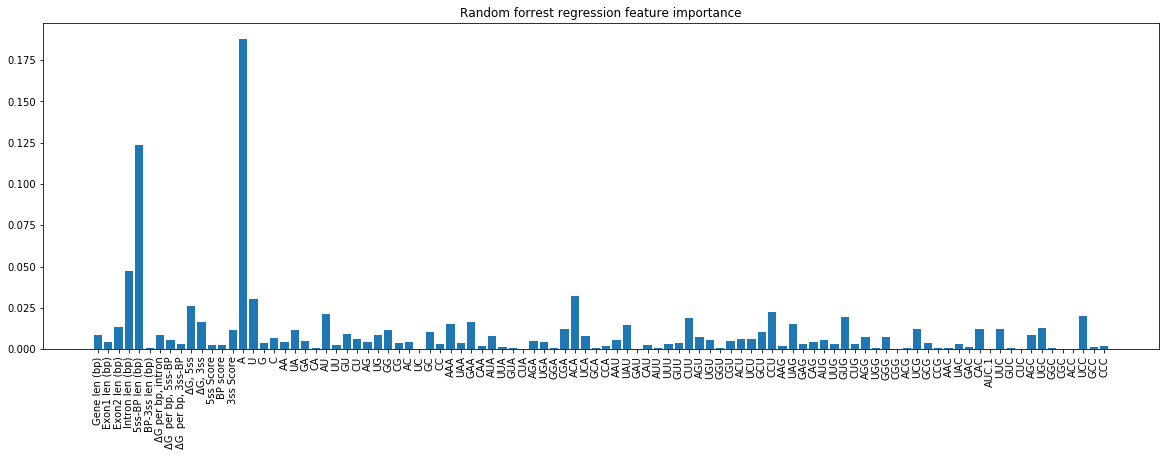

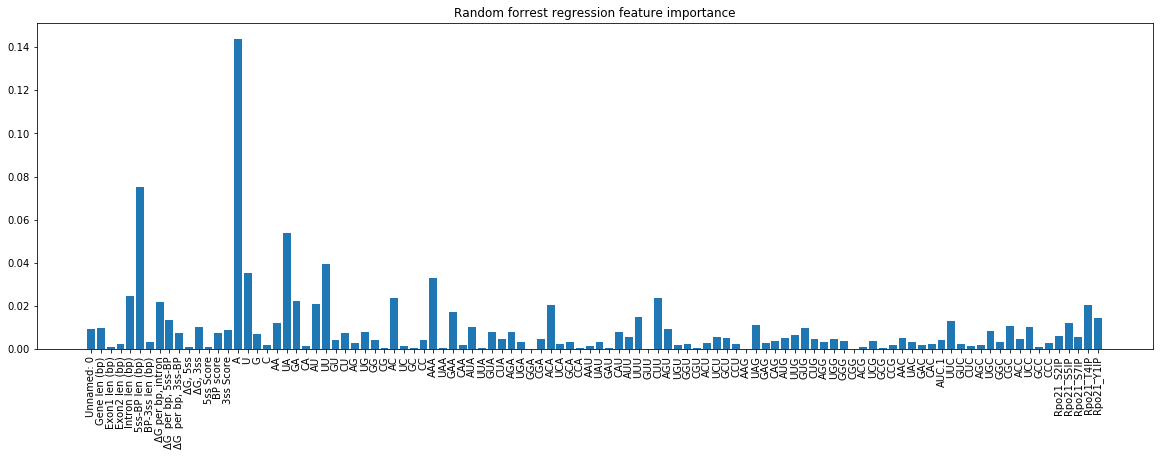

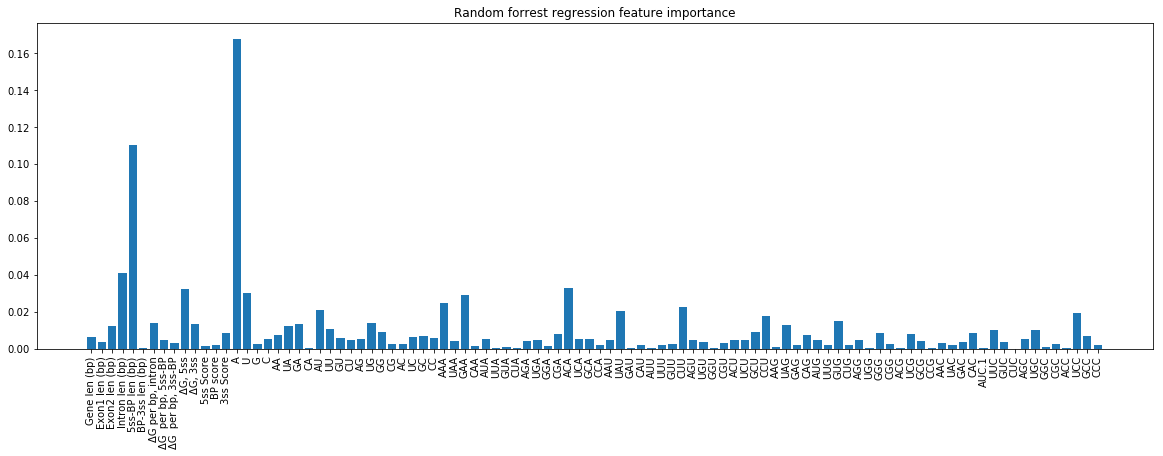

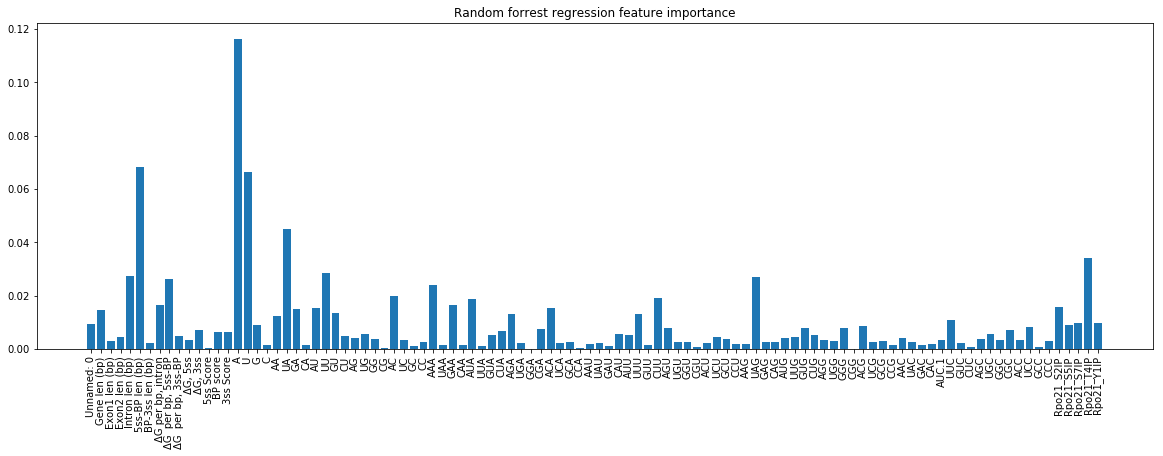

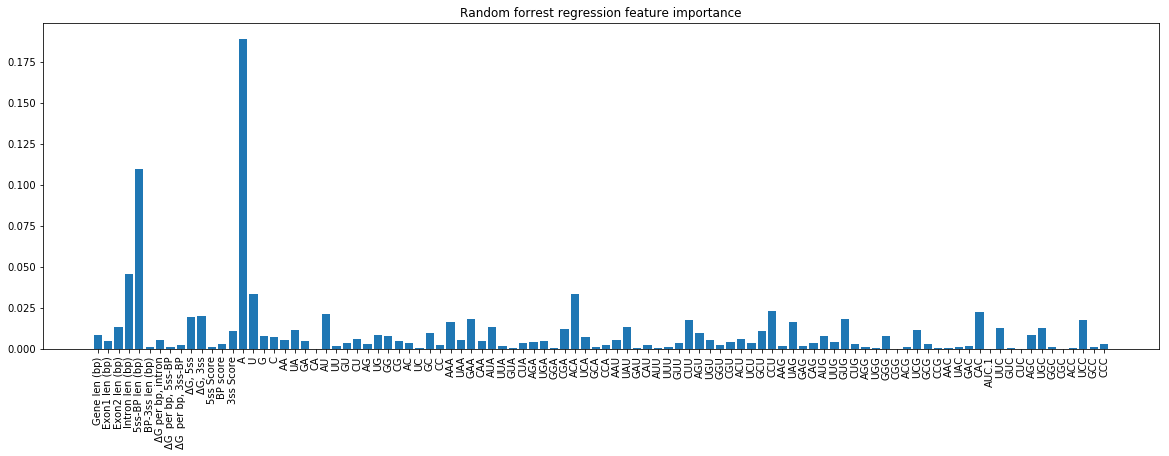

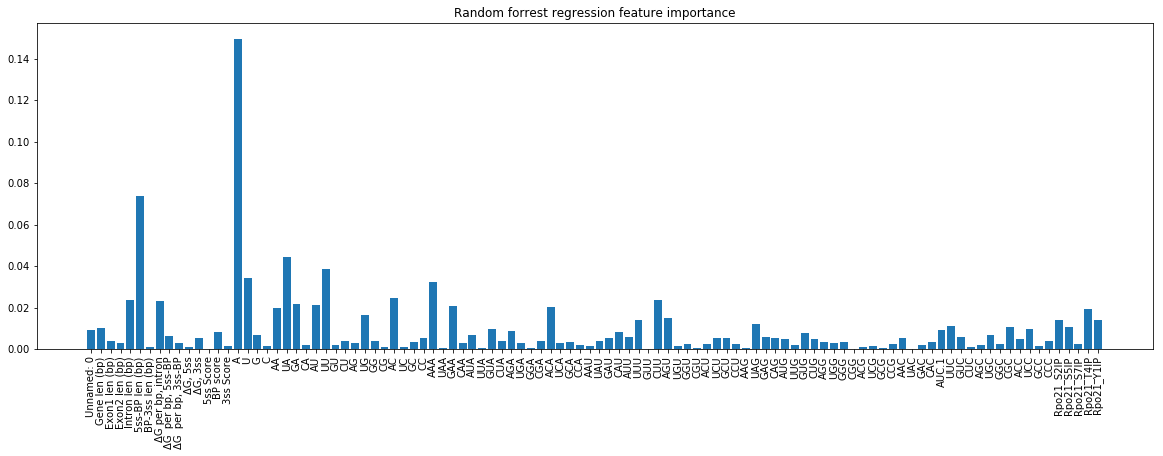

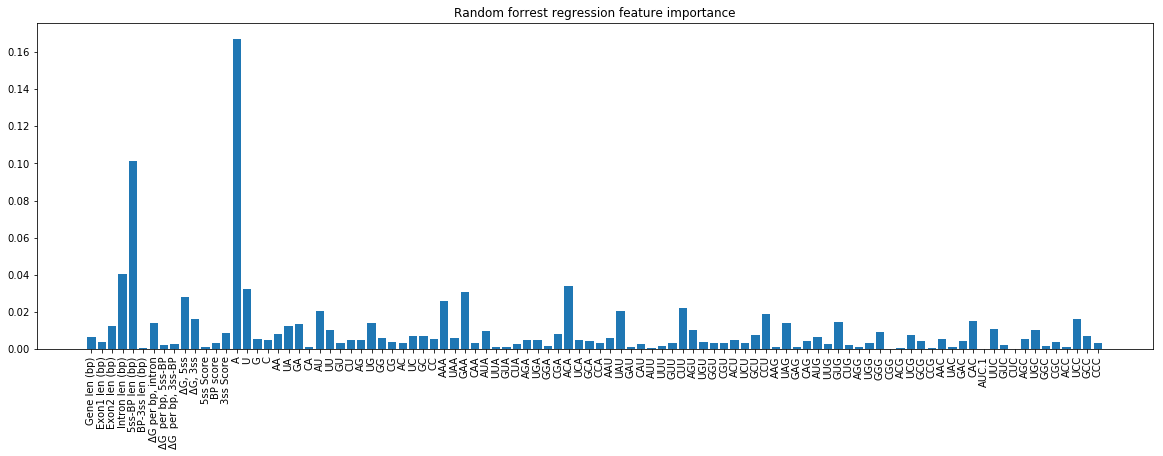

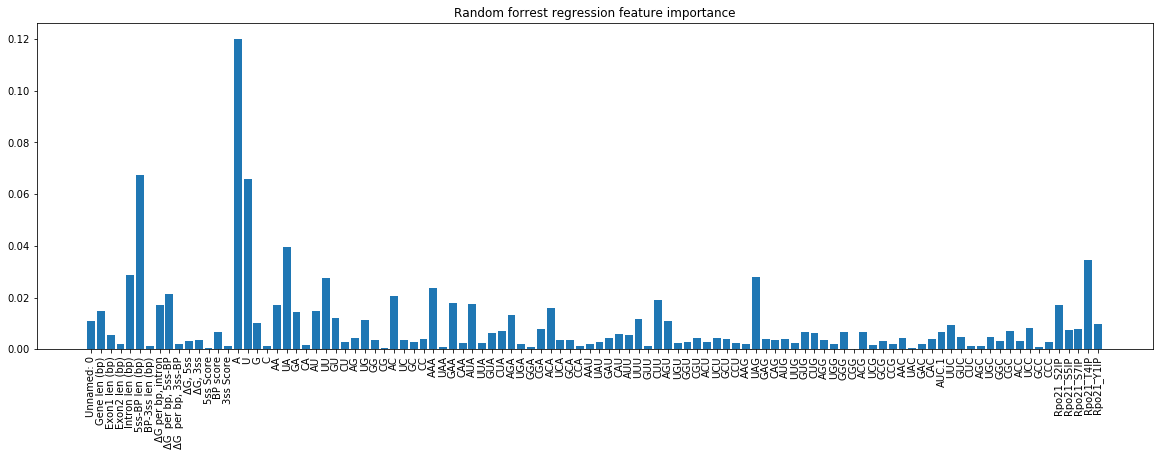

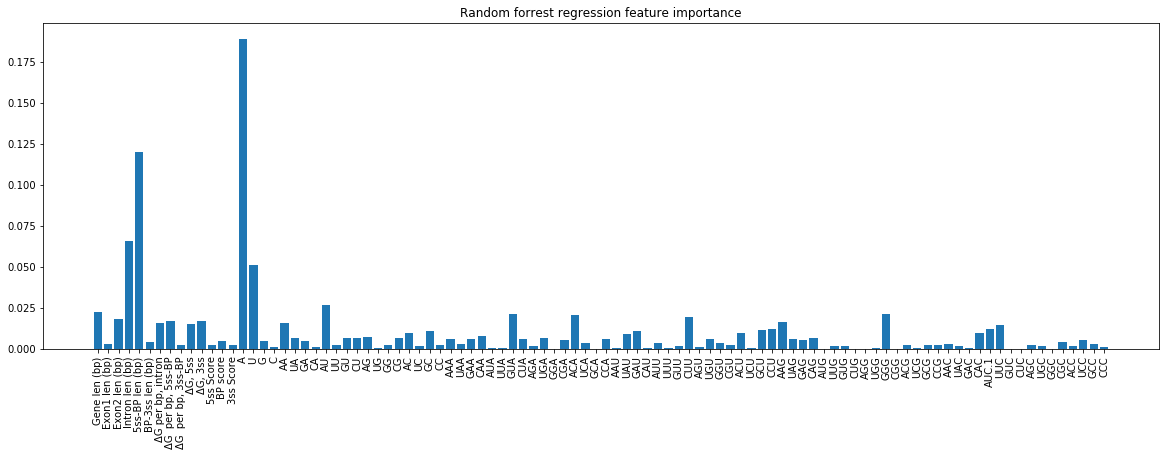

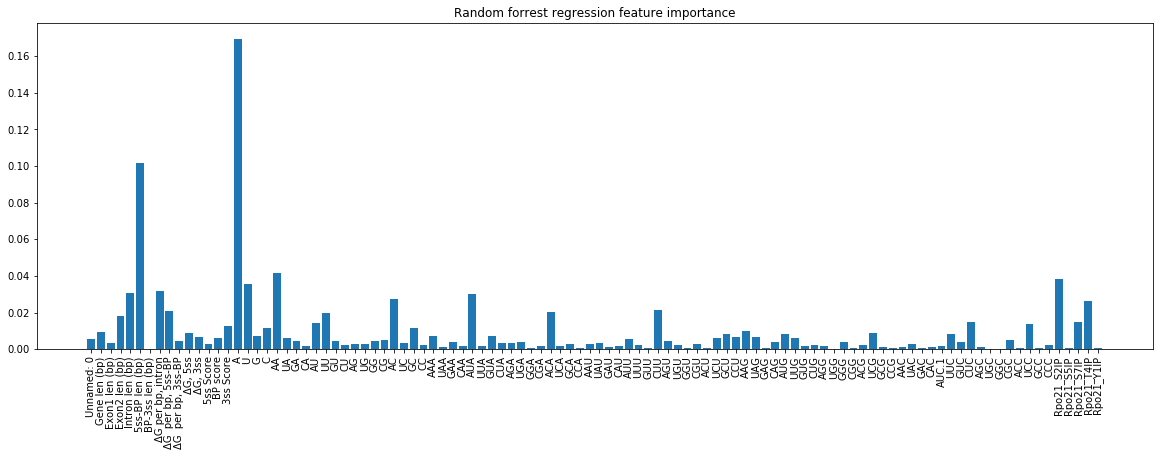

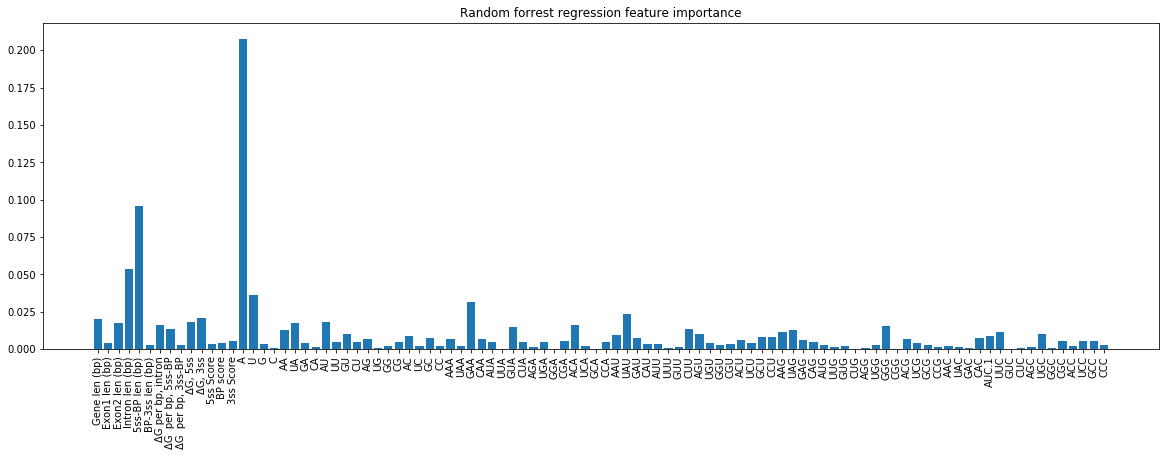

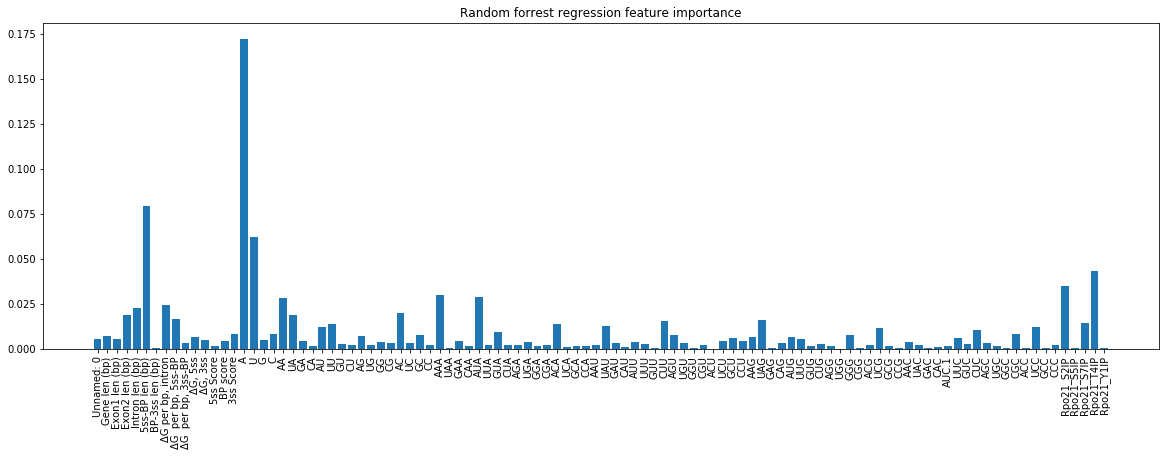

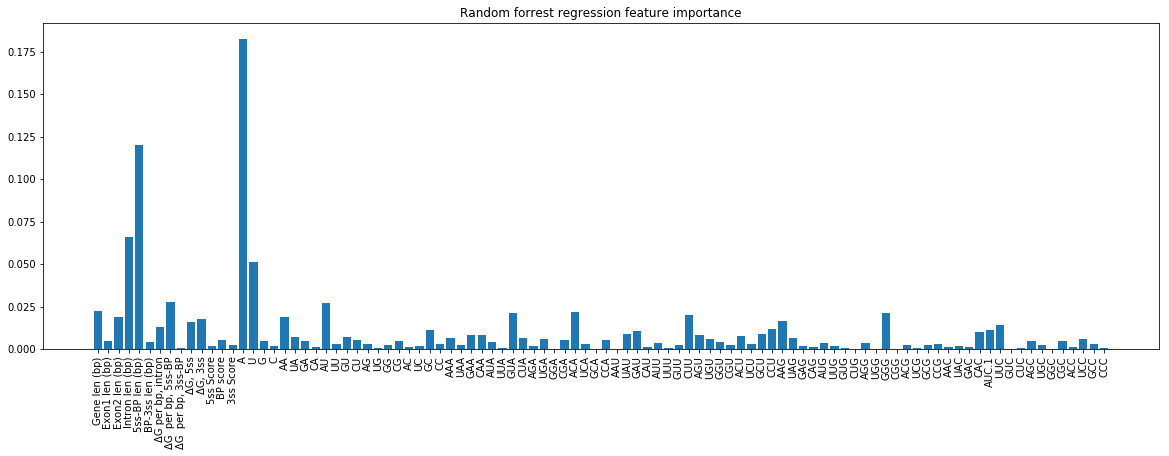

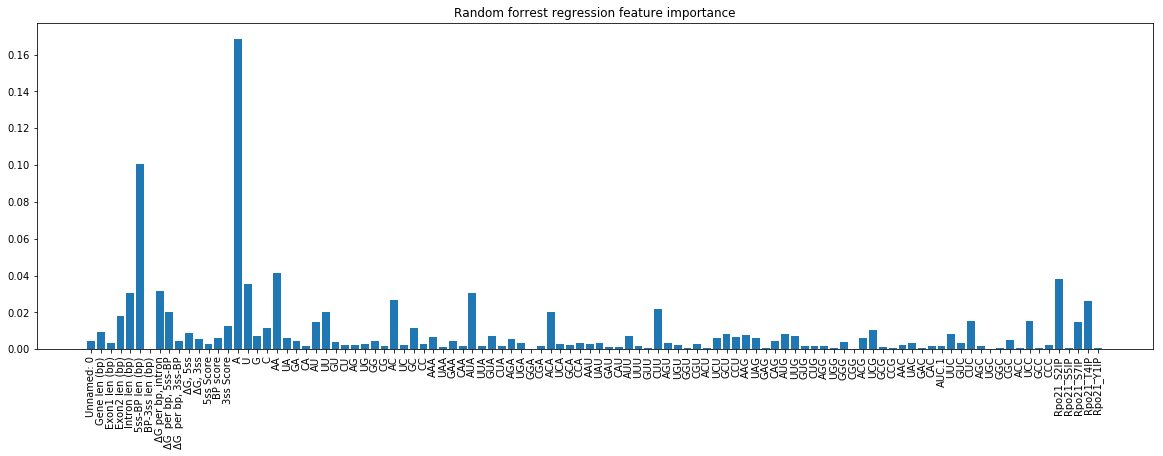

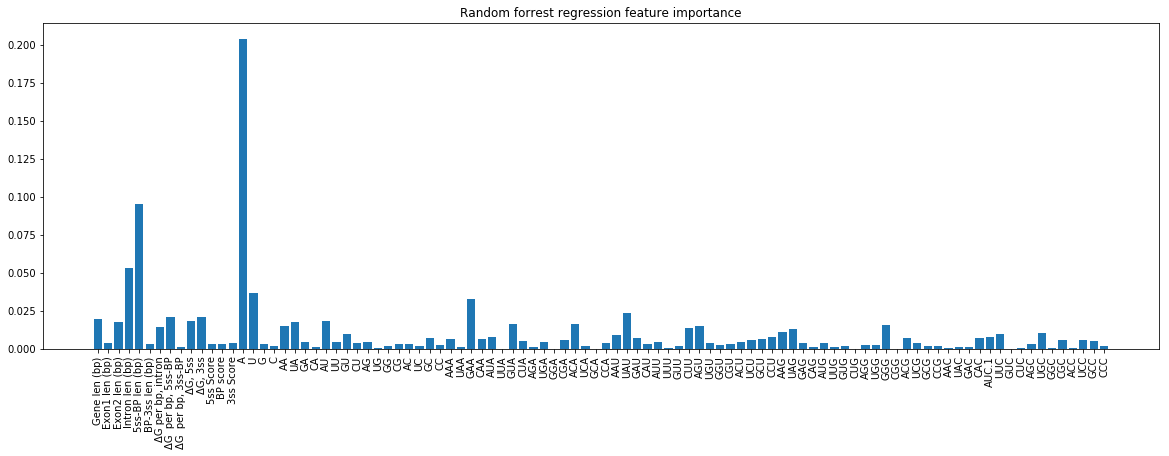

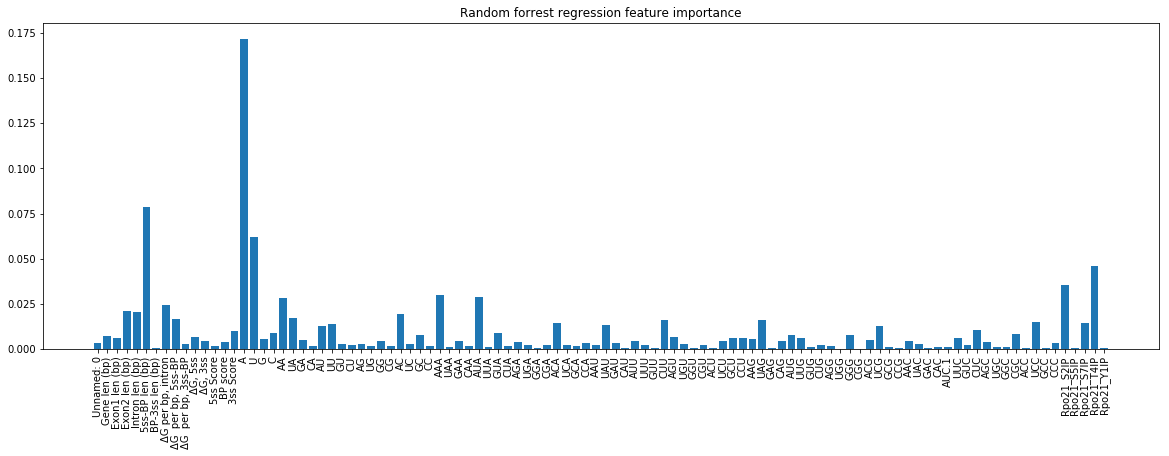

In [26]:
from ipywidgets import FloatProgress
from IPython.display import display

f = FloatProgress(min=0, max=1080)
display(f)

results_1 = np.zeros((12,10,9))
results_2 = np.zeros((12,10,9))
i = 0
for max_features in [25,50]:
    j = 0
    for max_depth in [10,15]:
        k = 0
        for n_estimators in [20,30]:
            
            
            kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

            rfr1 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X_extended,y=y_extended,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr1)))
            print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr1)))
            print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr1)))
            print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
            print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr1)[0][1]))
            
            print('\n')
            print('Extended feature space')
            print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr2)))
            print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr2)))
            print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr2)))
            print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr2))))
            print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr2)[0][1]))
            print('-------------------------------------------------------\n')
            
            
#             results_1[i][j][k]=r2_score(y, predictions_rfr1)
#             results_2[i][j][k]=r2_score(y, predictions_rfr2)
            f.value += 1
            
#             k += 1
#         j += 1
#     i += 1
            rfr1.fit(X,y)
            fig, ax1 = plt.subplots(figsize=(20,6))
            xx = np.arange(len(rfr1.feature_importances_))
            ax1.bar(xx, rfr1.feature_importances_)
            ax1.set_xticks(xx)
            ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
            ax1.set_title('Random forrest regression feature importance')
#             fig.savefig('Features_importance.png')

            rfr2.fit(X_extended,y_extended)
            fig2, ax2 = plt.subplots(figsize=(20,6))
            xx = np.arange(len(rfr2.feature_importances_))
            ax2.bar(xx, rfr2.feature_importances_)
            ax2.set_xticks(xx)
            ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
            ax2.set_title('Random forrest regression feature importance')
#             fig2.savefig('Features_importance2.png')

# Lasso

In [7]:
kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

lrl1 = Lasso()

lrl2 = Lasso()

predictions_rfr1 = cross_val_predict(lrl1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(lrl2,X_extended,y=y_extended,cv=kf)

print('Normal feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr1)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr1)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr1)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr1)[0][1]))

lrl1.fit(X,y)
# fig, ax1 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr1.feature_importances_))
# ax1.bar(xx, rfr1.feature_importances_)
# ax1.set_xticks(xx)
# ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax1.set_title('Random forrest regression feature importance')
# fig.savefig('Features_importance.png')
print('\n')
print('Extended feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr2)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr2)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr2)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr2))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr2)[0][1]))

lrl2.fit(X_extended,y_extended)
# fig2, ax2 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr2.feature_importances_))
# ax2.bar(xx, rfr2.feature_importances_)
# ax2.set_xticks(xx)
# ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax2.set_title('Random forrest regression feature importance')
# fig2.savefig('Features_importance2.png')

Normal feature space
Coefficient of determination R^2: 0.3002059626406446
Mean squared error:               0.03649757178502856
Mean absolute error:              0.14752323421884786
Root mean squared error:          0.19104337671070556
Correlation Coefficient:          0.5485330662093058


Extended feature space
Coefficient of determination R^2: 0.3002059626406445
Mean squared error:               0.03649757178502857
Mean absolute error:              0.14752323421884786
Root mean squared error:          0.1910433767107056
Correlation Coefficient:          0.5485330662093056


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [12]:
kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

lrl1 = LassoCV(cv=3)

lrl2 = LassoCV(cv=3)

predictions_rfr1 = cross_val_predict(lrl1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(lrl2,X_extended,y=y_extended,cv=kf)

print('Normal feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr1)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr1)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr1)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr1)[0][1]))

lrl1.fit(X,y)
# fig, ax1 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr1.feature_importances_))
# ax1.bar(xx, rfr1.feature_importances_)
# ax1.set_xticks(xx)
# ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax1.set_title('Random forrest regression feature importance')
# fig.savefig('Features_importance.png')
print('\n')
print('Extended feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr2)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr2)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr2)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr2))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr2)[0][1]))

lrl2.fit(X_extended,y_extended)
# fig2, ax2 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr2.feature_importances_))
# ax2.bar(xx, rfr2.feature_importances_)
# ax2.set_xticks(xx)
# ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax2.set_title('Random forrest regression feature importance')
# fig2.savefig('Features_importance2.png')

Normal feature space
Coefficient of determination R^2: 0.26706300759348933
Mean squared error:               0.03822613378530802
Mean absolute error:              0.153336477372941
Root mean squared error:          0.19551504746517087
Correlation Coefficient:          0.5169765486985246


Extended feature space
Coefficient of determination R^2: 0.29285414262975407
Mean squared error:               0.03688100400118547
Mean absolute error:              0.14922460768060203
Root mean squared error:          0.192044276147938
Correlation Coefficient:          0.5463879572133933


LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


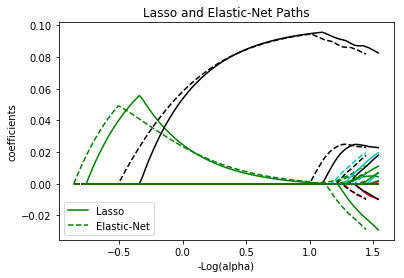

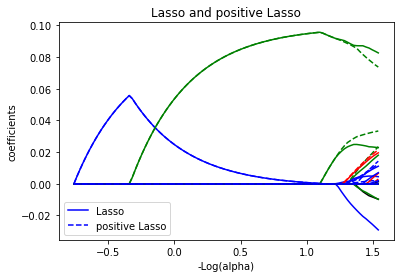

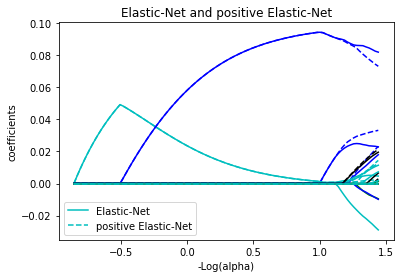

In [8]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets


X /= X.std(axis=0)  # Standardize data (easier to set the l1_ratio parameter)

# Compute paths

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps, positive=True, fit_intercept=False)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

# Display results

plt.figure(1)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')


plt.figure(2)
ax = plt.gca()
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.axis('tight')


plt.figure(3)
ax = plt.gca()
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net and positive Elastic-Net')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

In [4]:
# data_pca = pca.transform(data)
# y_true = digits.target

kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

svc_score_array = np.zeros((5,1));
svc_pca_score_array = np.zeros((5,1));
gaus_score_array = np.zeros((5,1));
gaus_pca_score_array = np.zeros((5,1));

i = 0;
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    X_train_pca, X_test_pca = X_extended[train_index], X_extended[test_index]
    
    y_train, y_test = y[train_index], y[test_index]

    svc_lin = SVC(kernel='linear',shrinking=False,random_state=1337)
    svc_lin.fit(X_train, y_train)

    svc_lin_pca = SVC(kernel='linear',shrinking=False,random_state=1337)
    svc_lin_pca.fit(X_train_pca, y_train)

    gaus = GaussianNB()
    gaus.fit(X_train,y_train)

    gaus_pca = GaussianNB()
    gaus_pca.fit(X_train_pca,y_train)


    svc_score_array[i] = svc_lin.score(X_test, y_test)
    svc_pca_score_array[i] = svc_lin_pca.score(X_test_pca, y_test)
    gaus_score_array[i] = gaus.score(X_test, y_test)
    gaus_pca_score_array[i] = gaus_pca.score(X_test_pca, y_test)

    i = i + 1;
    
svc_mean_performance = svc_score_array.mean(axis=0);
svc_pca_mean_performance = svc_pca_score_array.mean(axis=0);
gaus_mean_performance = gaus_score_array.mean(axis=0);
gaus_pca_mean_performance = gaus_pca_score_array.mean(axis=0);

print("Mean accuracy of SVC on digit data: {}".format(svc_mean_performance[0]))
print("Mean accuracy of SVC on pca transformed digit data: {}".format(svc_pca_mean_performance[0]))
print("Mean accuracy of SVC on digit data: {}".format(gaus_mean_performance[0]))
print("Mean accuracy of SVC on pca transformed digit data: {}".format(gaus_pca_mean_performance[0]))

KeyError: '[  2   7  10  13  16  22  24  26  43  50  59  61  62  73  74  86  91  93\n  94  95 101 108 112 116] not in index'

In [ ]:
kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

svc1 = SVR(kernel='poly',shrinking=False)
svc2 = SVR(kernel='poly',shrinking=False)

predictions_rfr1 = cross_val_predict(svc1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(svc2,X_extended,y=y_extended,cv=kf)

print('Normal feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr1)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr1)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr1)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr1)[0][1]))

# rfr1.fit(X,y)
# fig, ax1 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr1.feature_importances_))
# ax1.bar(xx, rfr1.feature_importances_)
# ax1.set_xticks(xx)
# ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax1.set_title('Random forrest regression feature importance')

print('\n')
print('Extended feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr2)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr2)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr2)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr2))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr2)[0][1]))

# rfr2.fit(X_extended,y_extended)
# fig2, ax2 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr2.feature_importances_))
# ax2.bar(xx, rfr2.feature_importances_)
# ax2.set_xticks(xx)
# ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax2.set_title('Random forrest regression feature importance')